# Librerias

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
import seaborn as sns

import statsmodels.api as sm

import yfinance as yf

from pypfopt import EfficientFrontier, expected_returns
from pypfopt import risk_models
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov
from pypfopt import objective_functions


import riskfolio as rp

import quantstats as qs

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Datos

## Funcion de descarga

In [3]:
def download(tickers, start, end, threshold=0.20):
    # Crear un DataFrame vacío para almacenar los datos
    acciones_df = yf.download(tickers, start=start, end=end)['Adj Close']
    
    # Obtener la lista de columnas del DataFrame resultante
    acciones_cols = acciones_df.columns.tolist()
    print(f"Total columns: {len(acciones_df.columns)}")
    
    # Detectar cuáles tickers no están en las columnas del DataFrame
    for ticker in tickers:
        if ticker not in acciones_cols:
            print(f"Ticker not found in DataFrame: {ticker}")
    
    # Eliminar columnas con más del threshold de sus valores como NA
    threshold1 = (acciones_df.isna().sum()*100)/ (len(acciones_df))
    columns_to_drop = acciones_df.columns[threshold1 > threshold].tolist()
    
    # Eliminar esas columnas del DataFrame
    acciones_df.drop(columns=columns_to_drop, inplace=True)
    
    # Mandar un mensaje con el nombre de las columnas eliminadas
    if columns_to_drop:
        print(f"Las siguientes columnas fueron eliminadas porque contienen más del {threshold*100}% de sus valores como NA: {', '.join(columns_to_drop)}")
        print(f"Total de columnas eliminadas: {len(columns_to_drop)}")
    else:
        print(f"No se encontraron columnas con más del {threshold/10}% de sus valores como NA.")
    
    # Arreglar nombre de columnas
    acciones_col = acciones_df.columns.tolist()
    acciones_df.columns = acciones_col
    
    acciones_df.dropna(inplace=True)
    return acciones_df

## Descarga

In [4]:
# Fecha de inicio
start = '2020-12-31'
end = '2024-12-01'

### Cripto

In [5]:
# Obtener datos de criptomonedas con Yahoo Finance
tk_cry = ['BTC-USD', 'ETH-USD','XRP-USD', 'BNB-USD', 'SOL-USD']
tk_cry.sort() 
cripto = yf.download(tk_cry, start=start)['Adj Close']
cripto.columns = [tk.split('-')[0] for tk in tk_cry]
cripto.dropna(inplace=True)
cripto.head()

[*********************100%***********************]  5 of 5 completed


,BNB,BTC,ETH,SOL,XRP
Date,,,,,
2020-12-31 00:00:00+00:00,37.376034,29001.720703,737.803406,1.510898,0.219846
2021-01-01 00:00:00+00:00,37.905010,29374.152344,730.367554,1.842084,0.237444
2021-01-02 00:00:00+00:00,38.241592,32127.267578,774.534973,1.799275,0.221655
2021-01-03 00:00:00+00:00,41.148979,32782.023438,975.507690,2.161752,0.225848
2021-01-04 00:00:00+00:00,40.926353,31971.914062,1040.233032,2.485097,0.236677


### Materias

In [6]:
# Definir los tickers de los principales commodities
commodities_tickers = {
    'Oro': 'GC=F',
    'Petroleo': 'CL=F',
    'Plata': 'SI=F',
    'Cobre': 'HG=F',
    'Gas_Natural': 'NG=F',
    'Trigo': 'ZW=F',
    'Maiz': 'ZC=F',
    'Soja': 'ZS=F'
}

tickers_materias = list(commodities_tickers.values())
materias =  yf.download(tickers_materias, start=start, end=end)['Adj Close']
materias.dropna(inplace=True)

# Renombrar en funcion de su valor en el diccionario
materias.columns = [key for key in commodities_tickers.keys()]
# Mostrar los primeros datos del DataFrame
materias.head()

[*********************100%***********************]  8 of 8 completed


,Oro,Petroleo,Plata,Cobre,Gas_Natural,Trigo,Maiz,Soja
Date,,,,,,,,
2020-12-31 00:00:00+00:00,48.520000,1893.099976,3.5140,2.539,26.332001,484.00,1315.25,640.50
2021-01-04 00:00:00+00:00,47.619999,1944.699951,3.5530,2.581,27.284000,483.75,1316.50,642.00
2021-01-05 00:00:00+00:00,49.930000,1952.699951,3.6405,2.702,27.570999,491.75,1350.00,654.00
2021-01-06 00:00:00+00:00,50.630001,1906.900024,3.6500,2.716,26.973000,495.00,1365.25,647.50
2021-01-07 00:00:00+00:00,50.830002,1912.300049,3.6955,2.729,27.200001,494.00,1360.50,642.25


### Indices

In [7]:
# Definir los tickers de los principales índices bursátiles de cada país
indices_paises = {
    'China': '000001.SS',
    'Australia': '^AXJO',
    'Brazil': '^BVSP',
    'Reino_Unido': '^FTSE',
    'Alemania': '^GDAXI',
    'USA': '^GSPC',
    'Canada': '^GSPTSE',
    'España': '^IBEX',
    'Argentina': '^MERV',
    'Mexico': '^MXX',
    'Japon': '^N225',
    'India': '^NSEI',
    'Europa': '^STOXX50E'
}

# Descargar los datos de indices desde el directorio y que la columna se llame como el nombre del directorio
tickers_indices = list(indices_paises.values())
indices =  yf.download(tickers_indices, start=start, end=end)['Adj Close']
indices.dropna(inplace=True)

# Renombrar en funcion de su valor en el diccionario
indices.columns = [key for key in indices_paises.keys()]
# Mostrar los primeros datos del DataFrame
indices.head()

[*********************100%***********************]  13 of 13 completed


,China,Australia,Brazil,Reino_Unido,Alemania,USA,Canada,España,Argentina,Mexico,Japon,India,Europa
Date,,,,,,,,,,,,,
2021-01-04 00:00:00+00:00,3502.958008,6684.200195,118558.0,6571.899902,13726.740234,3700.649902,17527.800781,8099.200195,50731.0,44703.000000,27258.380859,14132.900391,3564.389893
2021-01-05 00:00:00+00:00,3528.677002,6681.899902,119223.0,6612.299805,13651.219727,3726.860107,17682.500000,8091.500000,51595.0,44908.121094,27158.630859,14199.500000,3547.850098
2021-01-06 00:00:00+00:00,3550.876953,6607.100098,119851.0,6841.899902,13891.969727,3748.139893,17828.099609,8350.299805,51880.0,45587.160156,27055.939453,14146.250000,3611.080078
2021-01-07 00:00:00+00:00,3576.205078,6712.000000,121956.0,6857.000000,13968.240234,3803.790039,18027.599609,8385.799805,52501.0,46188.660156,27490.130859,14137.349609,3622.419922
2021-01-08 00:00:00+00:00,3570.110107,6757.899902,125077.0,6873.299805,14049.530273,3824.679932,18042.099609,8407.700195,51674.0,46729.300781,28139.029297,14347.250000,3645.050049


### Acciones por pais

#### Mexico

In [8]:
# Definir los tickers de las empresas de la Bolsa Mexicana de Valores
tickers_mexico = [
    'ALFAA.MX', 'ALSEA.MX', 'AMXB.MX', 'AC.MX', 'ASURB.MX', 'BBAJIOO.MX', 'CUERVO.MX', 'BIMBOA.MX', 'BOLSAA.MX', 'CEMEXCPO.MX',
    'KOFUBL.MX', 'VOLARA.MX', 'VESTA.MX', 'ELEKTRA.MX', 'GFNORTEO.MX', 'FEMSAUBD.MX', 'GCC.MX', 'LABB.MX', 'GENTERA.MX', 'GMEXICOB.MX',
    'GRUMAB.MX', 'GAPB.MX', 'GCARSOA1.MX', 'CHDRAUIB.MX', 'GFINBURO.MX', 'TLEVISACPO.MX', 'KIMBERA.MX', 'MEGACPO.MX', 'OMAB.MX', 'ORBIA.MX',
    'PE&OLES.MX', 'PINFRA.MX', 'Q.MX', 'RA.MX', 'WALMEX.MX'
]

# Descargar los datos de precios de las acciones de la Bolsa Mexicana de Valores
mex_acciones = download(tickers_mexico, start = start, end=end, threshold=0.20)
mex_acciones.dropna(inplace=True)
       
# Mostrar los primeros datos del DataFrame
mex_acciones.head()

[*********************100%***********************]  35 of 35 completed

Total columns: 35
No se encontraron columnas con más del 0.02% de sus valores como NA.


,AC.MX,ALFAA.MX,ALSEA.MX,AMXB.MX,ASURB.MX,BBAJIOO.MX,BIMBOA.MX,BOLSAA.MX,CEMEXCPO.MX,CHDRAUIB.MX,...,OMAB.MX,ORBIA.MX,PE&OLES.MX,PINFRA.MX,Q.MX,RA.MX,TLEVISACPO.MX,VESTA.MX,VOLARA.MX,WALMEX.MX
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31 00:00:00+00:00,81.532806,13.045583,25.465109,12.910334,283.813934,18.076994,40.524750,37.665939,10.266412,27.445478,...,93.695580,44.130863,336.622833,149.925217,89.228310,71.029312,30.543747,38.277863,24.770000,51.006290
2021-01-04 00:00:00+00:00,80.024513,13.054654,25.897888,12.910334,283.969086,17.460732,40.159237,38.424686,10.386370,28.018053,...,93.863441,44.178062,382.071594,152.230042,90.452560,70.443184,31.028858,39.274521,23.889999,52.136120
2021-01-05 00:00:00+00:00,81.779922,12.973007,25.770023,12.910334,285.960541,17.447481,40.346676,38.464619,10.656275,27.388220,...,94.454552,44.045906,381.321960,148.525238,89.944534,70.119270,32.027088,38.524563,23.510000,52.810368
2021-01-06 00:00:00+00:00,82.453110,13.000222,26.124113,12.910334,303.081421,17.546879,40.224846,38.808060,11.545964,27.960796,...,98.526680,44.432934,380.522339,145.520416,90.069466,70.103851,32.586834,39.195580,24.190001,54.496002
2021-01-07 00:00:00+00:00,85.512306,13.027438,26.291325,13.340677,298.133057,17.619772,40.787170,39.199409,11.645928,28.151655,...,99.468086,45.282516,389.927917,151.256897,90.627449,71.584587,34.088833,39.531094,23.900000,53.493732


#### Estados unidos

In [9]:
# Lista de empresas del Syp500
tickers_sp500 = [
    'BA', 'GM', 'CVX', 'C', 'BAC', 'T', 'CAT', 'INTC', 'MSFT', 'F', 'EBAY', 'DELL', 'DIS', 'DOW', 'CSCO', 'DE', 'FDX', 'GIS', 'GLW', 'GS',
    'JPM', 'KMB', 'KHC', 'KO', 'MCD', 'LLY', 'ORCL', 'MRK', 'MSI', 'MMM', 'VRTX', 'MNST', 'FITB', 'CTAS', 'ADSK', 'GILD', 'GOOGL', 'FISV', 'ADBE', 'QCOM', 'WBD', 'AMAT', 'STLD', 'CDNS', 'MCHP', 'WYNN', 'ISRG', 'NDAQ', 'HSIC', 'PAYX', 'VRSN', 'AAPL', 'FAST', 'NTRS', 'CHRW', 'PCAR', 'AMZN', 'ROST', 'NTAP', 'GRMN', 'COST', 'LRCX', 'INTU', 'EXPE', 'CTSH', 'AKAM', 'KLAC', 'JNPR', 'AMGN', 'EXPD', 'EA', 'TROW', 'BIIB', 'SCHW', 'HBAN', 'GEN', 'NVDA', 'SBUX', 'CINF', 'AXON', 'HOLX', 'CMCSA', 'MDT', 'DOV', 'NOC', 'MGM', 'MA', 'GD', 'DTE', 'ADI', 'CAH', 'XEL', 'DHI', 'IPG', 'LMT', 'WAT', 'ACN', 'D', 'XOM', 'CI', 'PEG', 'NI', 'ZBH', 'CSX', 'ICE', 'LUV', 'ITW', 'DRI', 'TFC', 'HAL', 'PLD', 'MKC', 'HST', 'EL', 'IP', 'EMR', 'CLX', 'COP', 'CL', 'PNW', 'RF', 'CNP', 'MET', 'EXC', 'BAX', 'OXY', 'SO', 'TPR', 'LEN', 'CPB', 'STT', 'PGR', 'VMC', 'PH', 'GPC', 'CBRE', 'DD', 'SHW', 'PFE', 'WFC', 'WMT', 'EIX', 'SNA', 'EFX', 'MCK', 'ETR', 'CMS', 'AMP', 'AIG', 'RL', 'IFF', 'GWW', 'STZ', 'AMT', 'PM', 'FIS', 'MO', 'BALL', 'HIG', 'HSY', 'MS', 'PNC', 'WM', 'COR', 'AIZ', 'KR', 'TAP', 'HD', 'BDX', 'SJM', 'BBY', 'ADM', 'BF-B', 'IBM', 'UNP', 'MU', 'AVY', 'MRO', 'CF', 'APA', 'DUK', 'KEY', 'LH', 'BXP', 'WDC', 'PPG', 'SPGI', 'WMB', 'ELV', 'J', 'EMN', 'VZ', 'NUE', 'OMC', 'AVB', 'MAR', 'IR', 'BMY', 'AEP', 'TMO', 'NEM', 'PSA', 'TRV', 'SWK', 'BEN', 'HUM', 'PARA', 'CB', 'JNJ', 'TSN', 'TGT', 'JBL', 'AXP', 'MAS', 'SYK', 'DFS', 'PRU', 'ABT', 'GE', 'DGX', 'UPS', 'CVS', 'PPL', 'SPG', 'JCI', 'CMI', 'ALL', 'SRE', 'DVN', 'CAG', 'TJX', 'FE', 'GL', 'RTX', 'PHM', 'VLO', 'BSX', 'COF', 'PCG', 'NSC', 'AFL', 'EQR', 'APD', 'PFG', 'TXN', 'HPQ', 'HON', 'AMD', 'MTB', 'MOS', 'RVTY', 'LVS', 'FCX', 'AZO', 'SYY', 'AEE', 'ETN', 'CRM', 'ED', 'AES', 'TXT', 'USB', 'V', 'BKR', 'HES', 'YUM', 'MMC', 'K', 'KIM', 'ECL', 'EOG', 'AON', 'HAS', 'BK', 'SLB', 'WBA', 'ROK', 'PEP', 'UNH', 'TER', 'DHR', 'STX', 'A', 'DAL', 'MCO', 'NKE', 'PG', 'WY', 'ADP', 'KDP', 'LOW', 'UAL', 'NFLX', 'NWSA', 'EQIX', 'BKNG', 'ORLY', 'BLK', 'CME', 'JBHT', 'L', 'NEE', 'FSLR', 'VTRS', 'FFIV', 'EW', 'NWS', 'APH', 'BRK-B', 'CTRA', 'KMX', 'CMG', 'DVA', 'EQT', 'FMC', 'LHX', 'DOC', 'WELL', 'HRL', 'IVZ', 'IRM', 'ES', 'NRG', 'OKE', 'RSG', 'ROP', 'VTR', 'WEC', 'BX', 'MPC', 'AVGO', 'NXPI', 'TSLA', 'TTWO', 'DLTR', 'ALGN', 'ANSS', 'BLDR', 'CHTR', 'CSGP', 'DXCM', 'ERIE', 'FTNT', 'IDXX', 'INCY', 'JKHY', 'MKTX', 'MPWR', 'NDSN', 'ON', 'PTC', 'PODD', 'POOL', 'SMCI', 'TECH', 'ZBRA', 'BWA', 'TMUS', 'PWR', 'LDOS', 'TEL', 'MAA', 'CRL', 'HII', 'MTD', 'FRT', 'LYV', 'MLM', 'FDS', 'RJF', 'DLR', 'ESS', 'FICO', 'COO', 'MOH', 'EG', 'REG', 'DG', 'TDG', 'ATO', 'BRO', 'DPZ', 'HCA', 'HUBB', 'ROL', 'STE', 'RMD', 'MSCI', 'NVR', 'CCL', 'WST', 'TDY', 'TYL', 'TRGP', 'META', 'ARE', 'TFX', 'WAB', 'EVRG', 'WTW', 'CZR', 'ENPH', 'APTV', 'CCI', 'EPAM', 'PNR', 'MDLZ', 'SWKS', 'TSCO', 'DECK', 'LULU', 'REGN', 'URI', 'KMI', 'ALB', 'CNC', 'PSX', 'XYL', 'UDR', 'SBAC', 'IT', 'IEX', 'UHS', 'LKQ', 'BR', 'EXR', 'CPT', 'MHK', 'AWK', 'LNT', 'CE', 'BG', 'AME', 'WRB', 'LYB', 'RCL', 'CPAY', 'PKG', 'AJG', 'CHD', 'GNRC', 'GPN', 'O', 'AOS', 'ACGL', 'CBOE', 'CPRT', 'ODFL', 'SNPS', 'TRMB', 'ULTA', 'VRSK', 'ABBV', 'FANG', 'NCLH', 'ZTS', 'IQV', 'NOW', 'PANW', 'KKR','CDW', 'HLT', 'ALLE', 'GOOG', 'PAYC', 'ANET', 'SYF', 'CTLT', 'CFG', 'KEYS', 'QRVO', 'GDDY', 'PYPL', 'HPE', 'MTCH', 'FTV', 'LW', 'INVH', 'VST', 'VICI', 'DAY', 'MRNA', 'UBER', 'FOXA', 'FOX', 'CRWD', 'CTVA', 'AMCR', 'TT', 'OTIS', 'CARR', 'HWM', 'PLTR', 'ABNB', 'CEG', 'GEHC', 'KVUE', 'VLTO', 'LIN', 'GEV'
]

# Descargar los datos de precios d acciones del SP500
usa_acciones = download(tickers_sp500, start = start, end=end)
usa_acciones.dropna(inplace=True)
  
# Mostrar los primeros datos del DataFrame
usa_acciones.head()

[*********************100%***********************]  500 of 500 completed


Total columns: 500
Las siguientes columnas fueron eliminadas porque contienen más del 20.0% de sus valores como NA: CEG, FISV, GEHC, GEV, KVUE, MRO, VLTO
Total de columnas eliminadas: 7


,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31 00:00:00+00:00,115.460632,129.751587,91.254494,146.800003,101.929962,34.298908,246.602890,500.119995,137.608276,45.564987,...,200.036972,28.320217,110.736107,59.231094,34.925980,97.182640,100.815727,145.351929,384.329987,160.329376
2021-01-04 00:00:00+00:00,115.796387,126.544228,89.772614,139.149994,101.576210,33.186359,242.118469,485.339996,136.015457,45.076881,...,193.409653,27.712091,104.916145,58.333797,35.163227,95.177689,98.271194,144.474655,378.130005,158.479034
2021-01-05 00:00:00+00:00,116.743156,128.108765,90.700912,148.300003,102.833000,33.319485,243.496887,485.690002,138.446579,45.953651,...,191.795502,27.973923,108.145103,57.765194,36.857830,95.063118,98.280472,146.974426,380.570007,159.583420
2021-01-06 00:00:00+00:00,119.944542,123.796440,89.917412,142.770004,102.618904,34.783871,246.159103,466.309998,139.070679,47.815670,...,193.409653,28.117512,108.792839,59.044514,37.798344,99.073006,98.819099,151.162643,394.820007,161.927780
2021-01-07 00:00:00+00:00,123.136154,128.020798,90.879776,151.270004,103.615013,34.460564,248.481644,477.739990,144.948364,47.390846,...,194.881348,28.387789,107.713272,57.889587,38.094898,103.569832,98.066895,150.266495,409.100006,161.782471


#### China

In [10]:
# Lista de empresas del FTSE a50 Chino
tickers_ftse_china_a50 = [
    '601088.SS', '601988.SS', '600028.SS', '600000.SS', '600016.SS', '600018.SS', '600019.SS', '600030.SS', '600036.SS', '600050.SS',
    '600048.SS', '600104.SS', '600276.SS', '600519.SS', '600585.SS', '600887.SS', '600900.SS', '601166.SS', '601169.SS', '601186.SS',
    '601360.SS', '601336.SS', '601288.SS', '601318.SS', '601328.SS', '601390.SS', '601398.SS', '601601.SS', '601628.SS', '601668.SS',
    '601766.SS', '601800.SS', '601818.SS', '601857.SS', '601939.SS', '601998.SS', '603288.SS', '000002.SZ', '000651.SZ', '002415.SZ',
    '002304.SZ', '002352.SZ', '000333.SZ', '000001.SZ', '000858.SZ', '601211.SS', '001979.SZ', '300498.SZ', '601138.SS', '300760.SZ'
]

# Descargar los datos de precios de las acciones del FTSE a50 Chino
china_acciones = download(tickers_ftse_china_a50, start = start, end=end)
china_acciones.dropna(inplace=True)

# Mostrar los primeros datos del DataFrame
china_acciones.head()

[*********************100%***********************]  50 of 50 completed

Total columns: 50
No se encontraron columnas con más del 0.02% de sus valores como NA.


,000001.SZ,000002.SZ,000333.SZ,000651.SZ,000858.SZ,001979.SZ,002304.SZ,002352.SZ,002415.SZ,300498.SZ,...,601628.SS,601668.SS,601766.SS,601800.SS,601818.SS,601857.SS,601939.SS,601988.SS,601998.SS,603288.SS
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31 00:00:00+00:00,16.809929,24.280367,85.134735,47.032269,268.264618,11.420588,210.469894,83.760399,44.446136,17.425581,...,35.586063,4.129219,4.696704,6.544699,3.136364,3.395992,4.984232,2.498877,3.982849,109.605492
2021-01-04 00:00:00+00:00,16.166737,23.502041,85.627693,47.761215,273.963562,11.111226,220.271408,85.896416,45.628067,18.543955,...,35.066967,4.079369,4.670170,6.490610,3.057759,3.428724,4.960422,2.491019,3.967261,109.594559
2021-01-05 00:00:00+00:00,15.792990,23.612022,87.815735,49.553211,294.121338,11.119820,235.183319,88.763428,50.190872,18.954979,...,34.751801,4.054444,4.732084,6.472580,3.034177,3.420541,4.920738,2.491019,3.967261,109.999008
2021-01-06 00:00:00+00:00,17.001150,24.322668,87.314125,48.649620,301.769012,11.128412,228.851120,87.880539,50.777256,18.706450,...,36.142242,4.112602,5.209715,6.679919,3.081341,3.477823,4.968359,2.498877,3.967261,112.928528
2021-01-07 00:00:00+00:00,17.296669,24.356508,90.652405,49.127995,303.331604,11.179974,228.315994,87.595734,53.406830,18.467484,...,36.466679,4.087678,5.430840,6.598787,3.097062,3.477823,5.008041,2.506735,3.967261,117.279076


#### Bolsa Europa

In [11]:
# Lista de empresas del Eurostoxx 50
tickers_eurostoxx50 = [
    'INGA.AS', 'PHIA.AS', 'STLAP.PA', 'BAS.DE', 'BAYN.DE', 'ALV.DE', 'ADS.DE', 'SIE.DE', 'DPWA.F', 'MBG.DE', 'DB1.DE', 'AI.PA', 'CS.PA', 'BN.PA', 'BNP.PA', 'MC.PA', 'OR.PA', 'SU.PA', 'EL.PA', 'RI.PA', 'AIR.PA', 'SAN.PA', 'TTE.PA', 'DG.PA', 'BBVA.MC', 'ITX.MC', 'IBE.MC', 'SAN.MC', 'KNEBV.HE', 'BMW.DE', 'DTE.DE', 'IFX.DE', 'MUV2.DE', 'SAP.DE', 'KER.PA', 'FLTR.L', 'AD.AS', 'ASML.AS', 'ISP.MI', 'ENEL.MI', 'ENI.MI', 'RMS.PA', 'SAF.PA', 'ABI.BR', 'VOW3.DE', 'RACE.MI', 'ADYEN.AS', 'PRX.AS']

# Descarga individual
euro_acciones = download(tickers_eurostoxx50, start = start, end= end)
euro_acciones.dropna(inplace=True)

# Mostrar los primeros datos del DataFrame
euro_acciones.head()

[*********************100%***********************]  48 of 48 completed

Total columns: 48
Las siguientes columnas fueron eliminadas porque contienen más del 20.0% de sus valores como NA: ADS.DE, ALV.DE, BAS.DE, BAYN.DE, BBVA.MC, BMW.DE, DB1.DE, DPWA.F, DTE.DE, ENEL.MI, ENI.MI, FLTR.L, IBE.MC, IFX.DE, ISP.MI, ITX.MC, KNEBV.HE, MBG.DE, MUV2.DE, RACE.MI, SAN.MC, SAP.DE, SIE.DE, VOW3.DE
Total de columnas eliminadas: 24


,ABI.BR,AD.AS,ADYEN.AS,AI.PA,AIR.PA,ASML.AS,BN.PA,BNP.PA,CS.PA,DG.PA,...,OR.PA,PHIA.AS,PRX.AS,RI.PA,RMS.PA,SAF.PA,SAN.PA,STLAP.PA,SU.PA,TTE.PA
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31 00:00:00+00:00,54.471447,20.050531,1905.0,103.125801,86.308441,383.615021,46.818352,33.533653,15.259549,70.590851,...,289.962921,36.538727,40.164196,141.115067,858.905579,112.709549,67.429291,3.626625,109.498657,27.686121
2021-01-04 00:00:00+00:00,54.662544,20.640507,1859.5,104.815750,86.414192,392.010101,47.375713,33.459743,15.201676,71.770828,...,290.802582,38.111946,40.218746,142.825012,863.592590,112.903976,67.686325,3.626625,112.691978,27.642164
2021-01-05 00:00:00+00:00,54.633877,20.545071,1829.0,103.701904,86.356506,392.637299,47.549885,33.389729,15.195420,70.556129,...,287.817078,37.352463,41.036938,139.855118,849.531433,113.146988,67.677750,3.626625,111.627533,28.369488
2021-01-06 00:00:00+00:00,56.153076,20.614475,1733.0,103.932365,86.683365,388.729279,47.967907,35.233479,15.844529,73.263176,...,288.096954,37.632053,40.482384,137.830200,847.578552,113.049782,67.266495,3.626625,114.728302,29.616325
2021-01-07 00:00:00+00:00,55.799553,20.579771,1714.5,104.738930,86.154633,389.742401,47.218956,36.026985,15.942286,73.384644,...,286.977417,37.281521,38.073261,140.125092,854.804443,112.563744,66.589630,3.626625,117.088593,29.940018


#### España

In [12]:
# Lista de empresas del IBEX 35
tickers_ibex35 = [
    'ACS.MC', 'ACX.MC', 'BBVA.MC', 'BKT.MC', 'ANA.MC', 'CABK.MC', 'ENG.MC', 'NTGY.MC', 'GRF.MC', 'FER.MC', 'RED.MC', 'ITX.MC', 'REP.MC', 'IBE.MC', 'IDR.MC', 'MAP.MC', 'TEF.MC', 'SCYR.MC', 'SAB.MC', 'SAN.MC', 'COL.MC', 'IAG.MC', 'ELE.MC', 'AMS.MC', 'ROVI.MC', 'SLR.MC', 'FDR.MC', 'MTS.MC', 'MRL.MC', 'LOG.MC', 'AENA.MC', 'CLNX.MC', 'UNI.MC', 'ANE.MC', 'PUIG.MC']


# Descargar los datos de precios de las acciones del IBEX 35
es_acciones = download(tickers_ibex35, start = start, end=end)


# Mostrar los primeros datos del DataFrame
es_acciones.head()

[*********************100%***********************]  35 of 35 completed

Total columns: 35
Las siguientes columnas fueron eliminadas porque contienen más del 20.0% de sus valores como NA: ANE.MC, PUIG.MC
Total de columnas eliminadas: 2


,ACS.MC,ACX.MC,AENA.MC,AMS.MC,ANA.MC,BBVA.MC,BKT.MC,CABK.MC,CLNX.MC,COL.MC,...,NTGY.MC,RED.MC,REP.MC,ROVI.MC,SAB.MC,SAN.MC,SCYR.MC,SLR.MC,TEF.MC,UNI.MC
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31 00:00:00+00:00,20.350677,7.234211,131.935242,57.739609,102.505699,3.197324,2.483562,1.663203,45.254555,6.863122,...,15.118577,13.201488,6.798978,35.449249,0.298870,2.189645,1.636955,23.639999,2.460211,0.626508
2021-01-04 00:00:00+00:00,20.245741,7.442412,128.502335,56.285458,102.857048,3.231397,2.438652,1.685368,47.115593,6.811810,...,15.202304,13.421841,6.680305,35.823380,0.293635,2.214234,1.612643,24.520000,2.501151,0.627385
2021-01-05 00:00:00+00:00,20.575548,7.456828,128.316772,56.440563,102.330032,3.228227,2.521737,1.689326,46.415401,6.833190,...,15.094656,13.108094,7.194556,36.571655,0.304442,2.221998,1.613453,26.580000,2.519346,0.601974
2021-01-06 00:00:00+00:00,21.025290,7.637803,130.914642,57.758995,104.965149,3.414441,2.675556,1.785113,43.789677,6.867399,...,15.377729,13.192071,7.293451,38.161724,0.323860,2.374704,1.672611,28.240000,2.643684,0.608984
2021-01-07 00:00:00+00:00,20.792921,7.863621,129.244583,55.063965,110.762375,3.448514,2.787833,1.852401,43.080265,6.790430,...,15.752506,13.076105,7.319822,39.284130,0.344291,2.409645,1.659645,30.940001,2.717225,0.617746


#### Alemania

In [13]:
# Lista de empresas del DAX Aleman
dax_tickers = [
    "BAS.DE", "BAYN.DE", "ALV.DE", "ADS.DE", "SIE.DE", "DBK.DE", "CON.DE", "DPWA.F", "MBG.DE", "PAH3.DE", "HEN3.DE", "CBK.DE", "DB1.DE", "BMW.DE", "DTE.DE", "MRK.DE", "IFX.DE", "MUV2.DE", "SAP.DE", "RHM.DE", "BEI.DE", "FRE.DE", "HNR1.DE", "RWE.DE", "MTX.DE", "SY1.DE", "HEI.DE", "QIA.DE", "EOAN.DE", "BNR.DE", "SRT3.DE", "VOW3.DE", "VNA.DE", "ZAL.DE", "1COV.DE", "AIR.DE", "SHL.DE", "ENR.DE", "DTG.DE", "P911.DE"]


# Descargar los datos de precios de las acciones del DAX Aleman
ale_acciones = download(dax_tickers, start=start, end=end)

# Mostrar los primeros datos del DataFrame
ale_acciones.head()

[*********************100%***********************]  40 of 40 completed

Total columns: 40
Las siguientes columnas fueron eliminadas porque contienen más del 20.0% de sus valores como NA: DTG.DE, P911.DE
Total de columnas eliminadas: 2


,1COV.DE,ADS.DE,AIR.DE,ALV.DE,BAS.DE,BAYN.DE,BEI.DE,BMW.DE,BNR.DE,CBK.DE,...,RHM.DE,RWE.DE,SAP.DE,SHL.DE,SIE.DE,SRT3.DE,SY1.DE,VNA.DE,VOW3.DE,ZAL.DE
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04 00:00:00+00:00,46.774498,284.892242,86.340652,162.429550,50.021694,43.941284,92.477402,55.347527,59.073349,4.988481,...,82.006371,32.500244,98.436691,40.021187,105.258720,345.171875,105.710205,40.041870,94.407555,94.080002
2021-01-05 00:00:00+00:00,46.394505,279.298553,86.388710,160.761261,49.643970,44.106205,91.563705,54.577305,58.583786,5.114433,...,81.166718,31.822216,98.174988,40.179821,105.043930,350.515717,104.604042,40.230743,93.619141,96.599998
2021-01-06 00:00:00+00:00,47.679222,281.323853,86.648254,169.119095,51.933449,45.849056,91.369308,54.677437,59.726082,5.402597,...,81.446602,33.051708,98.586227,41.182915,109.071007,343.192627,103.065048,38.611797,93.759026,96.099998
2021-01-07 00:00:00+00:00,49.036316,278.237671,86.138779,167.728836,52.735157,46.642483,90.786110,54.700539,61.829372,5.446490,...,82.248940,33.322918,97.688965,41.056942,111.236687,341.015594,101.526039,38.368958,94.229523,96.540001
2021-01-08 00:00:00+00:00,49.018223,284.602905,86.677086,168.260406,52.866203,45.911465,91.447067,54.292328,61.883766,5.215577,...,82.454178,34.941154,99.240486,41.654133,110.968208,351.505310,101.958878,38.868134,93.123192,97.580002


#### Reino Unido

In [14]:
# Lista de empresas del FTSE 100 ingles
FTSE_tickers = [
    "BATS.L", "HSBA.L", "BARC.L", "IHG.L", "BP.L", "NXT.L", "LLOY.L", "EZJ.L", "MKS.L", "NWG.L", "PRU.L", "VOD.L", 
    "AZN.L", "LGEN.L", "IMB.L", "RKT.L", "KGF.L", "REL.L", "CNA.L", "III.L", "WPP.L", "TSCO.L", "DGE.L", "HIK.L", 
    "FCIT.L", "RIO.L", "AAL.L", "BNZL.L", "GSK.L", "BDEV.L", "AV.L", "SGE.L", "PSON.L", "ABF.L", "LSEG.L", "BA.L", 
    "ANTO.L", "RR.L", "WTB.L", "VTY.L", "PSN.L", "ADM.L", "UU.L", "ULVR.L", "SSE.L", "STAN.L", "INF.L", "WEIR.L", 
    "SVT.L", "SMIN.L", "MRO.L", "SN.L", "ITRK.L", "MNDI.L", "SBRY.L", "CRDA.L", "NG.L", "IMI.L", "BT-A.L", "SGRO.L", 
    "SDR.L", "RTO.L", "CPG.L", "ICG.L", "HSX.L", "LAND.L", "SMT.L", "HLMA.L", "RMV.L", "FRAS.L", "SMDS.L", "TW.L", 
    "SPX.L", "AHT.L", "UTG.L", "FLTR.L", "BEZ.L", "FRES.L", "EXPN.L", "BKG.L", "HWDN.L", "GLEN.L", "IAG.L", "JD.L", 
    "LMP.L", "PHNX.L", "DCC.L", "SHEL.L", "ENT.L", "DPLM.L", "CCH.L", "AUTO.L", "BME.L", "CTEC.L", "PSH.L", "MNG.L", 
    "AAF.L", "HLN.L"]


# Descargar los datos de precios de las acciones del FTSE 100 ingles
uk_acciones = download(FTSE_tickers, start=start, end=end)

# Mostrar los primeros datos del DataFrame
uk_acciones.head()

[*********************100%***********************]  98 of 98 completed

1 Failed download:
['BDEV.L']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2020-12-31 -> 2024-12-01) (Yahoo error = "No data found, symbol may be delisted")')


Total columns: 98
Las siguientes columnas fueron eliminadas porque contienen más del 20.0% de sus valores como NA: AAL.L, BDEV.L, BP.L, CRDA.L, GLEN.L, HLN.L, IAG.L, LLOY.L, PSH.L, SHEL.L, VOD.L, WPP.L
Total de columnas eliminadas: 12


,AAF.L,ABF.L,ADM.L,AHT.L,ANTO.L,AUTO.L,AV.L,AZN.L,BA.L,BARC.L,...,STAN.L,SVT.L,TSCO.L,TW.L,ULVR.L,UTG.L,UU.L,VTY.L,WEIR.L,WTB.L
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31 00:00:00+00:00,63.900913,2137.640625,2597.880615,3264.851318,1249.763184,563.989319,265.731628,6672.347656,430.063354,126.780518,...,414.058044,1942.130249,206.996552,124.394737,3803.438721,930.799438,748.094116,803.031250,1869.734375,2859.543457
2021-01-04 00:00:00+00:00,62.886627,2101.761475,2681.020264,3323.728760,1303.119751,572.695129,266.875610,6761.628418,434.550507,124.049240,...,411.836273,1982.008301,212.005936,118.392578,3863.191162,897.843018,762.303711,765.422607,1938.809937,2783.904053
2021-01-05 00:00:00+00:00,65.591415,2079.101074,2707.839600,3358.865234,1306.590088,568.342163,268.183014,6777.115234,440.621399,123.772644,...,414.235840,1965.038818,213.079391,120.981018,3841.541748,904.968689,752.273438,789.782715,1917.194458,2811.576904
2021-01-06 00:00:00+00:00,67.873604,2135.752686,2698.899658,3467.123535,1374.261963,577.048096,284.035400,6843.620117,444.316681,134.006363,...,453.073212,2018.492310,219.341156,123.494438,3868.387207,894.280151,779.355286,812.006042,1980.161011,2898.285645
2021-01-07 00:00:00+00:00,67.366440,2105.538330,2661.352783,3479.469238,1378.166382,552.066101,285.914856,6809.911621,439.301636,134.939850,...,455.206146,2000.674316,220.056808,123.757019,3851.068115,903.187256,773.169800,805.168091,1976.401855,2872.457275


#### Japon

In [15]:
# lista de empresas del Nikkei 225 Japones
tickers_nikkei = [
    '1332.T', '4088.T', '5714.T', '7011.T', '8604.T', '4063.T', '7012.T', '1605.T', '4151.T', '5801.T', '7013.T', '8630.T', '1721.T', '4183.T', '5802.T', '7201.T', '8725.T', '1801.T', '4188.T', '5803.T', '7202.T', '1802.T', '4208.T', '8750.T', '1803.T', '6103.T', '7205.T', '8766.T', '1812.T', '4324.T', '6113.T', '7211.T', '8795.T', '1925.T', '4452.T', '6301.T', '7261.T', '8801.T', '1928.T', '4502.T', '6302.T', '7267.T', '8802.T', '1963.T', '4503.T', '6305.T', '7269.T', '2002.T', '4506.T', '6326.T', '7270.T', '8804.T', '2269.T', '6361.T', '7731.T', '2282.T', '4519.T', '7733.T', '8830.T', '2501.T', '4523.T', '6367.T', '7735.T', '9001.T', '2502.T', '4543.T', '6471.T', '7751.T', '9005.T', '2503.T', '4568.T', '6472.T', '7752.T', '9007.T', '2531.T', '4689.T', '6473.T', '7762.T', '9008.T', '2768.T', '4704.T', '6479.T', '7911.T', '9009.T', '2801.T', '4901.T', '6501.T', '7912.T', '9020.T', '2802.T', '4902.T', '7951.T', '9021.T', '2871.T', '4911.T', '6503.T', '8001.T', '9022.T', '2914.T', '6504.T', '8002.T', '9147.T', '3086.T', '5020.T', '6506.T', '8015.T', '9064.T', '3099.T', '5101.T', '8031.T', '9101.T', '5108.T', '6674.T', '8035.T', '9104.T', '5201.T', '6701.T', '8053.T', '9107.T', '6702.T', '8058.T', '9202.T', '5214.T', '8233.T', '9301.T', '3382.T', '5232.T', '6752.T', '8252.T', '3401.T', '5233.T', '8253.T', '9432.T', '3402.T', '5301.T', '6758.T', '8267.T', '9433.T', '3405.T', '5332.T', '6762.T', '3407.T', '5333.T', '9501.T', '3436.T', '5401.T', '6770.T', '8304.T', '9502.T', '3861.T', '5406.T', '8306.T', '9503.T', '3863.T', '5411.T', '6841.T', '8308.T', '9531.T', '6857.T', '9532.T', '5413.T', '6902.T', '8316.T', '9533.T', '4004.T', '5631.T', '6952.T', '8331.T', '9613.T', '6954.T', '4021.T', '5706.T', '6971.T', '8354.T', '9735.T', '6976.T', '5831.T', '9766.T', '4042.T', '5711.T', '8411.T', '9983.T', '4043.T', '5713.T', '5932.T', '8601.T', '9984.T', '3289.T', '6988.T', '6723.T', '2432.T', '9201.T', '8591.T', '6861.T', '6981.T', '2413.T', '3659.T', '4578.T', '4631.T', '4661.T', '5019.T', '6273.T', '6594.T', '6645.T', '6724.T', '7272.T', '7741.T', '7832.T', '7974.T', '9843.T', '4751.T', '4755.T', '6098.T', '6920.T', '8697.T', '6178.T', '1808.T', '8309.T', '6753.T', '8358.T', '7203.T', '4385.T', '9434.T']

# Descargar los datos de precios de las acciones del Nikkei 225 Japones
jp_acciones = download(tickers_nikkei, start = start, end=end)

# Mostrar los primeros datos del DataFrame
jp_acciones.head()

[*********************100%***********************]  223 of 223 completed

1 Failed download:
['5413.T']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2020-12-31 -> 2024-12-01)')


Total columns: 223
Las siguientes columnas fueron eliminadas porque contienen más del 20.0% de sus valores como NA: 5413.T, 5831.T, 9147.T
Total de columnas eliminadas: 3


,1332.T,1605.T,1721.T,1801.T,1802.T,1803.T,1808.T,1812.T,1925.T,1928.T,...,9503.T,9531.T,9532.T,9533.T,9613.T,9735.T,9766.T,9843.T,9983.T,9984.T
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04 00:00:00+00:00,379.091370,469.624603,2808.442139,3143.017090,757.741333,676.317017,973.455261,1177.679565,2681.855957,1787.905884,...,855.257080,2150.768311,1873.801025,6352.066895,1355.315796,4249.794922,5478.070312,20738.847656,29368.591797,7796.720215
2021-01-05 00:00:00+00:00,377.290436,473.058777,2742.926514,3080.691162,749.208313,663.521851,977.580139,1171.649048,2644.387451,1772.136475,...,848.555054,2135.801025,1857.639893,6324.248535,1349.556274,4206.296387,5544.184082,21126.761719,28762.189453,7808.403809
2021-01-06 00:00:00+00:00,384.494171,502.249390,2742.926514,3129.661621,765.421265,679.972900,978.405273,1181.125610,2677.447510,1762.333862,...,865.963074,2145.325684,1870.209717,6324.248535,1348.596558,4226.686035,5496.959473,21737.724609,28049.345703,7905.766113
2021-01-07 00:00:00+00:00,385.394592,514.268982,2777.867920,3160.824463,773.954407,693.681885,992.429504,1202.663208,2725.054443,1781.512817,...,879.541321,2158.478516,1887.268799,6481.891113,1392.749756,4306.887695,5421.399414,22023.812500,28497.697266,7782.116211
2021-01-08 00:00:00+00:00,392.598236,522.854431,2839.016113,3165.276123,788.460632,701.907532,1000.679016,1217.308960,2728.581055,1794.724976,...,887.374878,2175.260498,1903.430054,6296.429199,1425.385010,4372.589355,5638.634277,22295.351562,29587.927734,7777.248535


#### Argentina

In [16]:
# Listado de empresas del Merval Argentino
tickers_merval_yf = [
    "GGAL.BA", "TXAR.BA", "PAMP.BA", "TECO2.BA", "ALUA.BA", "BBAR.BA", "BMA.BA", "EDN.BA", "TRAN.BA", "MIRG.BA", "CEPU.BA", "COME.BA", "CRES.BA", "IRSA.BA", "METR.BA", "TGNO4.BA", "TGSU2.BA", "YPFD.BA", "SUPV.BA", "BYMA.BA", "VALO.BA", "LOMA.BA"]

# Descargar los datos de precios de las acciones del Merval Argentino
ar_acciones = download(tickers_merval_yf, start = start, end=end)

# Mostrar los primeros datos del DataFrame
ar_acciones.head()

[*********************100%***********************]  22 of 22 completed

Total columns: 22
No se encontraron columnas con más del 0.02% de sus valores como NA.


,ALUA.BA,BBAR.BA,BMA.BA,BYMA.BA,CEPU.BA,COME.BA,CRES.BA,EDN.BA,GGAL.BA,IRSA.BA,...,MIRG.BA,PAMP.BA,SUPV.BA,TECO2.BA,TGNO4.BA,TGSU2.BA,TRAN.BA,TXAR.BA,VALO.BA,YPFD.BA
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04 00:00:00+00:00,44.198658,116.532005,179.579178,11.470490,36.309807,2.080638,47.417004,28.100000,96.735809,45.108070,...,1562.925049,76.699997,57.481060,187.550003,38.624691,155.100006,29.250000,43.122429,25.128792,676.250000
2021-01-05 00:00:00+00:00,46.717754,114.886406,181.427551,11.432289,37.734680,2.089236,48.718655,27.750000,97.049751,44.583157,...,1547.665039,78.000000,57.011444,193.000000,40.318344,158.000000,29.200001,45.332722,24.733406,690.299988
2021-01-06 00:00:00+00:00,48.366615,113.470406,179.209534,11.527796,36.752007,2.106431,49.388073,27.549999,96.578827,44.618149,...,1550.618408,77.699997,56.776638,194.449997,40.412437,153.750000,29.049999,47.499683,25.040928,694.299988
2021-01-07 00:00:00+00:00,48.641426,111.709976,182.741943,11.518245,36.555473,2.097833,51.284752,27.150000,97.245979,47.732670,...,1546.187988,79.449997,56.260059,200.750000,39.706749,159.750000,28.700001,47.846397,24.733406,723.200012
2021-01-08 00:00:00+00:00,48.916237,111.442116,182.002579,11.508696,36.064140,2.072040,50.503761,26.900000,96.264885,47.417721,...,1563.909302,76.699997,55.931328,199.949997,38.954014,155.699997,27.850000,47.846397,24.733406,689.700012


#### Brasil

In [17]:
# Listado de empresas de Bovespa Brasil
tickers_bovespa_yf = [
    "RAIL3.SA", "ALPA4.SA", "ALLD3.SA", "ABEV3.SA", "AZUL4.SA", "BBAS3.SA", "BBDC3.SA", "BBDC4.SA", "BEEF3.SA", 
    "BRAP4.SA", "BRFS3.SA", "BRKM5.SA", "B3SA3.SA", "CCRO3.SA", "CMIG4.SA", "CPFE3.SA", "CPLE6.SA", "CSAN3.SA", 
    "CSNA3.SA", "CYRE3.SA", "ELET3.SA", "ELET6.SA", "EMBR3.SA", "EQTL3.SA", "YDUQ3.SA", "EZTC3.SA", "FLRY3.SA", 
    "GGBR4.SA", "GOAU4.SA", "PRIO3.SA", "HYPE3.SA", "ITSA4.SA", "ITUB4.SA", "JBSS3.SA", "LREN3.SA", "MGLU3.SA", 
    "ENEV3.SA", "MRFG3.SA", "MRVE3.SA", "MULT3.SA", "NTCO3.SA", "PETR3.SA", "PETR4.SA", "RENT3.SA", "SANB11.SA", 
    "SBSP3.SA", "SLCE3.SA", "SMTO3.SA", "EGIE3.SA", "TIMS3.SA", "TOTS3.SA", "TAEE11.SA", "TRPL4.SA", "UGPA3.SA", 
    "USIM5.SA", "VALE3.SA", "VIVT3.SA", "WEGE3.SA", "STBP3.SA", "COGN3.SA", "RADL3.SA", "BBSE3.SA", "CVCB3.SA", 
    "KLBN11.SA", "ENGI11.SA", "BPAC11.SA", "CRFB3.SA", "IRBR3.SA", "SUZB3.SA", "VBBR3.SA", "HAPV3.SA", "VAMO3.SA", 
    "VIVA3.SA", "PCAR3.SA", "LWSA3.SA", "PETZ3.SA", "BRAV3.SA", "RDOR3.SA", "CSNA3.SA", "ASAI3.SA", "CXSE3.SA", 
    "RECV3.SA", "RAIZ4.SA", "IGTI11.SA", "AURE3.SA"
]

# Descargar los datos de precios de las acciones de Bovespa Brasil
br_acciones = download(tickers_bovespa_yf, start = start, end=end)

# Mostrar los primeros datos del DataFrame
br_acciones.head()

[*********************100%***********************]  84 of 84 completed

Total columns: 84
Las siguientes columnas fueron eliminadas porque contienen más del 20.0% de sus valores como NA: ALLD3.SA, ASAI3.SA, AURE3.SA, BRAV3.SA, CXSE3.SA, IGTI11.SA, RAIZ4.SA, RECV3.SA, VAMO3.SA
Total de columnas eliminadas: 9


,ABEV3.SA,ALPA4.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BPAC11.SA,...,TOTS3.SA,TRPL4.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VBBR3.SA,VIVA3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04 00:00:00+00:00,13.386031,41.159180,37.730000,17.275015,13.906763,15.457430,17.461184,21.913918,8.185863,21.303047,...,26.290588,21.024248,9.815639,12.068116,61.610600,17.253990,27.053839,36.424370,35.084152,32.230839
2021-01-05 00:00:00+00:00,13.671393,41.178944,38.200001,17.309015,13.762484,15.383527,17.354719,21.503824,8.022799,21.142838,...,26.167469,20.887825,9.734249,12.197359,62.648003,17.451403,25.788218,36.115173,37.237534,32.391991
2021-01-06 00:00:00+00:00,13.948107,38.935696,36.669998,17.025726,14.076948,15.770241,17.929901,21.153379,7.908653,20.460812,...,24.926809,20.758980,9.616232,12.787032,64.702583,17.198713,25.007912,35.710804,38.224895,31.102758
2021-01-07 00:00:00+00:00,13.878927,38.243946,36.049999,17.501652,14.635585,16.156967,18.405912,21.600754,7.867887,20.590483,...,24.860518,20.395187,9.909236,13.400940,68.926270,17.514576,25.045973,34.806927,39.804661,31.491425
2021-01-08 00:00:00+00:00,14.294000,40.220375,36.599998,17.759445,14.720679,16.032427,18.247246,22.271816,7.933113,21.242722,...,26.517885,21.206146,10.165615,13.336319,68.710716,18.004166,25.217260,35.718731,42.211937,32.562626


#### India

In [18]:
# Lista de empresas del NIFTY 50 Indio
tickers_nifty_yf = [
    'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BHARTIARTL.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'INDUSINDBK.NS', 'INFY.NS', 'ITC.NS', 'JSWSTEEL.NS', 'KOTAKBANK.NS', 'LT.NS', 'M&M.NS', 'MARUTI.NS', 'NTPC.NS', 'POWERGRID.NS', 'RELIANCE.NS', 'SBIN.NS', 'SUNPHARMA.NS', 'TCS.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TECHM.NS', 'TITAN.NS', 'ULTRACEMCO.NS', 'WIPRO.NS', 'NESTLEIND.NS']

# Descargar los datos de precios de las acciones del NIFTY 50 Indio
in_acciones = download(tickers_nifty_yf, start = start, end=end)

# Mostrar los primeros datos del DataFrame
in_acciones.head()

[*********************100%***********************]  30 of 30 completed

Total columns: 30
No se encontraron columnas con más del 0.02% de sus valores como NA.


,ASIANPAINT.NS,AXISBANK.NS,BAJAJFINSV.NS,BAJFINANCE.NS,BHARTIARTL.NS,HCLTECH.NS,HDFCBANK.NS,HINDUNILVR.NS,ICICIBANK.NS,INDUSINDBK.NS,...,RELIANCE.NS,SBIN.NS,SUNPHARMA.NS,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,WIPRO.NS
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31 00:00:00+00:00,2674.681152,617.758423,889.068787,5218.990234,493.067535,814.357849,1378.817261,2252.488281,517.210693,864.256897,...,897.460083,258.795135,567.796875,182.714935,26.565207,2658.996094,864.336792,1542.526245,5177.920410,188.777512
2021-01-01 00:00:00+00:00,2685.372070,621.093811,885.485046,5204.157227,498.339691,818.101990,1368.017578,2245.106934,509.912415,869.278564,...,898.454651,262.983643,571.535217,185.348557,26.542509,2719.834473,868.555420,1534.110596,5180.515625,189.681686
2021-01-04 00:00:00+00:00,2664.232178,621.989929,888.310120,5141.127441,500.226105,843.837219,1359.329712,2281.732666,513.972412,867.057312,...,899.969055,264.536713,579.347412,190.118942,28.602020,2823.119629,889.870667,1526.531738,5216.157227,193.738251
2021-01-05 00:00:00+00:00,2703.077637,661.567505,880.533752,5045.326172,497.227234,853.261841,1369.601318,2304.347900,519.337341,890.041199,...,888.780701,265.195587,578.436829,192.007202,28.088169,2872.858154,891.558228,1546.266602,5229.865234,198.576813
2021-01-06 00:00:00+00:00,2714.204102,651.411743,877.089844,4957.902344,508.158478,841.943665,1363.697510,2273.081299,528.472290,890.717163,...,865.341797,268.301697,580.210144,194.193619,28.222305,2834.312012,885.607727,1547.890625,5334.781738,198.625702


#### Canada

In [19]:
# Lista de empresas del  Canadiense S&P/TSX GSPTSE
tickers_canada_yf = [
    'AAV.TO', 'ACO-X.TO', 'AEM.TO', 'AGI.TO', 'ALA.TO', 'AP-UN.TO', 'AQN.TO', 'ARX.TO', 'ATH.TO', 'BN.TO', 'BBD-B.TO', 'BCE.TO', 'BEI-UN.TO', 'WCN.TO', 'BIR.TO', 'BMO.TO', 'BNS.TO', 'BTE.TO', 'BTO.TO', 'CAE.TO', 'CAR-UN.TO', 'CCA.TO', 'CCL-B.TO', 'CG.TO', 'CIX.TO', 'CLS.TO', 'CM.TO', 'CNQ.TO', 'CP.TO', 'ARE.TO', 'CPX.TO', 'CS.TO', 'CSH-UN.TO', 'CTC-A.TO', 'CU.TO', 'CVE.TO', 'CWB.TO', 'SRU-UN.TO', 'DML.TO', 'DOL.TO', 'DPM.TO', 'ELD.TO', 'EMA.TO', 'EMP-A.TO', 'FCR-UN.TO', 'FFH.TO', 'FM.TO', 'FNV.TO', 'AG.TO', 'FRU.TO', 'CIGI.TO', 'FTS.TO', 'FTT.TO', 'FVI.TO', 'GIB-A.TO', 'GIL.TO', 'GWO.TO', 'HBM.TO', 'HR-UN.TO', 'IAG.TO', 'IFC.TO', 'IGM.TO', 'IMG.TO', 'IMO.TO', 'KEY.TO', 'L.TO', 'LB.TO', 'LAC.TO', 'LNR.TO', 'LUN.TO', 'MEG.TO', 'MFI.TO', 'MG.TO', 'MRU.TO', 'MTL.TO', 'MX.TO', 'NA.TO', 'NG.TO', 'NGD.TO', 'NPI.TO', 'NVA.TO', 'NWC.TO', 'ONEX.TO', 'OGC.TO', 'OTEX.TO', 'PAAS.TO', 'PD.TO', 'PEY.TO', 'PKI.TO', 'POU.TO', 'POW.TO', 'PPL.TO', 'PSI.TO', 'QBR-B.TO', 'RCI-B.TO', 'REI-UN.TO', 'RUS.TO', 'SAP.TO', 'TECK-B.TO', 'SLF.TO', 'WPM.TO', 'ATZ.TO', 'SPB.TO', 'SSRM.TO', 'STN.TO', 'T.TO', 'TA.TO', 'TRP.TO', 'TD.TO', 'TFII.TO', 'TIH.TO', 'TOU.TO', 'TRI.TO', 'TRP.TO', 'VET.TO', 'BHC.TO', 'WFG.TO', 'WN.TO', 'X.TO', 'AC.TO', 'ATS.TO', 'BDGI.TO', 'BDT.TO', 'BYD.TO', 'HWX.TO', 'CEU.TO', 'CRR-UN.TO', 'DSG.TO', 'LUG.TO', 'WSP.TO', 'IFP.TO', 'INE.TO', 'KMP-UN.TO', 'SIA.TO', 'MAG.TO', 'NWH-UN.TO', 'PBH.TO', 'SEA.TO', 'SES.TO', 'SHOP.TO', 'SII.TO', 'SSL.TO', 'TVE.TO', 'TXG.TO', 'WCP.TO', 'CSU.TO', 'AIF.TO', 'EFN.TO', 'EIF.TO', 'GEI.TO', 'GRT-UN.TO', 'IIP-UN.TO', 'PXT.TO', 'BLX.TO', 'BIP-UN.TO', 'BEP-UN.TO', 'DOO.TO', 'CJT.TO', 'CHP-UN.TO', 'DIR-UN.TO', 'GSY.TO', 'EFR.TO', 'ENGH.TO', 'EQB.TO', 'IVN.TO', 'KEL.TO', 'MTY.TO', 'NFI.TO', 'RCH.TO', 'SJ.TO', 'WDO.TO', 'WPK.TO', 'AYA.TO', 'CXB.TO', 'NXE.TO', 'OR.TO', 'QSR.TO', 'PSK.TO', 'EQX.TO', 'FSV.TO', 'TOY.TO', 'KXS.TO', 'H.TO', 'ATD.TO', 'CRT-UN.TO', 'OLA.TO', 'SIL.TO', 'KNT.TO', 'BBU-UN.TO', 'FIL.TO', 'ATZ.TO', 'TSU.TO', 'JWEL.TO', 'ABX.TO', 'CCO.TO', 'CNR.TO', 'ENB.TO', 'K.TO', 'MFC.TO', 'BB.TO', 'RY.TO', 'SU.TO', 'TECK-B.TO', 'NTR.TO', 'IPCO.TO', 'ERO.TO', 'LSPD.TO', 'GFL.TO', 'TPZ.TO', 'MDA.TO', 'TLRY.TO', 'PET.TO', 'ASTL.TO', 'DFY.TO', 'PMZ-UN.TO', 'SVI.TO', 'TFPM.TO', 'BN.TO', 'SOBO.TO']

# Descargar los datos de precios de las acciones del Canadiense S&P/TSX GSPTSE
ca_acciones = download(tickers_canada_yf, start=start, end=end)


# Mostrar los primeros datos del DataFrame
ca_acciones.head()

[*********************100%***********************]  215 of 215 completed

47 Failed downloads:
['TSU.TO', 'FNV.TO', 'IFP.TO', 'ENGH.TO', 'TA.TO', 'RY.TO', 'CM.TO', 'NPI.TO', 'ATH.TO', 'CPX.TO', 'ABX.TO', 'MEG.TO', 'PD.TO', 'NFI.TO', 'CWB.TO', 'KNT.TO', 'NWH-UN.TO', 'KEY.TO', 'LUG.TO', 'SII.TO', 'DOO.TO', 'BIP-UN.TO', 'GRT-UN.TO', 'OGC.TO', 'WSP.TO', 'ATS.TO', 'TOY.TO', 'SSL.TO', 'GSY.TO', 'ARX.TO', 'BYD.TO', 'TLRY.TO', 'BTE.TO', 'FTS.TO', 'IAG.TO', 'AG.TO', 'SES.TO', 'SLF.TO', 'WN.TO', 'RCI-B.TO', 'TIH.TO', 'MTL.TO', 'TRP.TO', 'BLX.TO', 'WFG.TO', 'BEP-UN.TO', 'ELD.TO']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


Total columns: 215
Las siguientes columnas fueron eliminadas porque contienen más del 20.0% de sus valores como NA: ABX.TO, AG.TO, ARX.TO, ASTL.TO, ATH.TO, ATS.TO, BEP-UN.TO, BIP-UN.TO, BLX.TO, BTE.TO, BYD.TO, CM.TO, CPX.TO, CWB.TO, DFY.TO, DOO.TO, ELD.TO, ENGH.TO, FNV.TO, FTS.TO, GRT-UN.TO, GSY.TO, IAG.TO, IFP.TO, KEY.TO, KNT.TO, LAC.TO, LUG.TO, MDA.TO, MEG.TO, MTL.TO, NFI.TO, NPI.TO, NWH-UN.TO, OGC.TO, PD.TO, PET.TO, PMZ-UN.TO, RCI-B.TO, RY.TO, SES.TO, SII.TO, SLF.TO, SOBO.TO, SSL.TO, TA.TO, TFPM.TO, TIH.TO, TLRY.TO, TOY.TO, TRP.TO, TSU.TO, WFG.TO, WN.TO, WSP.TO
Total de columnas eliminadas: 55


,AAV.TO,AC.TO,ACO-X.TO,AEM.TO,AGI.TO,AIF.TO,ALA.TO,AP-UN.TO,AQN.TO,ARE.TO,...,TRI.TO,TVE.TO,TXG.TO,VET.TO,WCN.TO,WCP.TO,WDO.TO,WPK.TO,WPM.TO,X.TO
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31 00:00:00+00:00,1.71,22.770000,30.488770,80.043503,10.709214,47.059685,16.049158,28.193270,16.808741,13.480814,...,94.203499,1.143244,19.090000,5.356037,127.326134,3.980410,10.62,39.307507,50.583191,23.322161
2021-01-04 00:00:00+00:00,1.70,22.110001,30.254824,85.958107,11.884147,46.810692,16.074879,28.021858,16.672346,13.480814,...,93.498177,1.134242,20.709999,5.356037,126.214043,3.947651,11.30,39.436016,55.121979,23.250624
2021-01-05 00:00:00+00:00,1.77,23.010000,30.304958,84.046135,11.633751,46.446774,16.392088,28.476469,16.616186,13.497293,...,94.076881,1.233264,20.469999,5.846377,125.736008,4.299825,10.95,39.839931,54.617668,23.268970
2021-01-06 00:00:00+00:00,1.74,22.719999,30.547264,85.582863,11.739685,46.303120,16.186331,28.327419,16.864904,13.637374,...,92.964668,1.260269,20.309999,6.053830,127.501724,4.291637,10.93,39.500275,54.655731,23.109379
2021-01-07 00:00:00+00:00,1.79,23.200001,30.747795,86.378014,11.537444,46.887299,16.289209,28.431755,17.105600,13.678576,...,92.467354,1.269271,20.670000,6.327290,128.643097,4.234304,10.82,39.867462,54.665253,23.296484


#### Australia

In [20]:
# Lista de empresas del ASX 200 Australiano
tickers_asx_yf = [
    'BHP.AX', 'AGL.AX', 'BSL.AX', 'AMC.AX', 'CSL.AX', 'MQG.AX', 'CBA.AX', 'LLC.AX', 'IAG.AX', 'FMG.AX', 'AMP.AX', 
    'BXB.AX', 'ASX.AX', 'ANZ.AX', 'GPT.AX', 'GMG.AX', 'CMW.AX', 'JHX.AX', 'HVN.AX', 'CDA.AX', 'JBH.AX', 'CGF.AX', 
    'MND.AX', 'IFL.AX', 'AMT.AX', 'APE.AX', 'COH.AX', 'CUV.AX', 'FLT.AX', 'ALL.AX', 'ORI.AX', 'ABG.AX', 'ALQ.AX', 
    'BPT.AX', 'ASB.AX', 'GNC.AX', 'LYC.AX', 'DOW.AX', 'NUF.AX', 'BEN.AX', 'BKW.AX', 'INA.AX', 'IRE.AX', 'MTS.AX', 
    'IPL.AX', 'MSB.AX', 'APA.AX', 'MGR.AX', 'PPT.AX', 'ILU.AX', 'DMP.AX', 'CHC.AX', 'PRN.AX', 'ANN.AX', 'BWP.AX', 
    'ORG.AX', 'IGO.AX', 'MIN.AX', 'PMV.AX', 'CPU.AX', 'CCP.AX', 'ARB.AX', 'AUB.AX', 'NAB.AX', 'VCX.AX', 'BOQ.AX', 
    'QBE.AX', 'REA.AX', 'REH.AX', 'RHC.AX', 'RIO.AX', 'RMD.AX', 'RSG.AX', 'SBM.AX', 'SEK.AX', 'SVW.AX', 
    'SGM.AX', 'SGP.AX', 'SHL.AX', 'SOL.AX', 'STO.AX', 'SUL.AX', 'SUN.AX', 'TAH.AX', 'TCL.AX', 'SPK.AX', 'TLS.AX', 
    'TNE.AX', 'CWY.AX', 'WBC.AX', 'WES.AX', 'WOR.AX', 'WOW.AX', 'WDS.AX', 'ELD.AX', 'DXS.AX', 'PTM.AX', 'WHC.AX', 
    'CHC.AX', 'PRU.AX', 'TPG.AX', 'FBU.AX', 'NWH.AX', 'AIA.AX', 'FPH.AX', 'NHF.AX', 'QUB.AX', 'RMS.AX', 'SKC.AX', 
    'CNU.AX', 'GOZ.AX', 'OBL.AX', 'NAN.AX', 'ALX.AX', 'MFG.AX', 'RRL.AX', 'GEM.AX', 'CAR.AX', 'PNV.AX', 'TWE.AX', 
    'EVN.AX', 'AZJ.AX', 'BRG.AX', 'WEB.AX', 'NST.AX', 'GOR.AX', 'NXT.AX', 'RFF.AX', 'NWS.AX', 'BGA.AX', 'CKF.AX', 
    'CTD.AX', 'CIP.AX', 'SDF.AX', 'NSR.AX', 'XRO.AX', 'SCG.AX', 'IPH.AX', 'MPL.AX', 'APX.AX', 'BAP.AX', 'CIA.AX', 
    'EML.AX', 'HUB.AX', 'PLS.AX', 'PME.AX', 'ZIP.AX', 'A2M.AX', 'S32.AX', 'IEL.AX', 'MP1.AX', 'WTC.AX', 'RWC.AX', 
    'NEC.AX', 'ORA.AX', 'QAN.AX', 'KGN.AX', 'WPR.AX', 'CLW.AX', 'ING.AX', 'WGX.AX', 'DHG.AX', 'NWL.AX', 'URW.AX', 
    'VEA.AX', 'NIC.AX', 'COL.AX', 'PBH.AX', 'ALD.AX', 'DRR.AX', 'NXL.AX'
]

# Descargar los datos de precios de las acciones del ASX 200 Australiano
au_acciones = download(tickers_asx_yf, start = start, end=end)

# Mostrar los primeros datos del DataFrame
au_acciones.head()

[*********************100%***********************]  168 of 170 completed

170 Failed downloads:
['TWE.AX', 'BRG.AX', 'IPH.AX', 'JHX.AX', 'SDF.AX', 'CBA.AX', 'RHC.AX', 'DRR.AX', 'VCX.AX', 'ING.AX', 'CNU.AX', 'CTD.AX', 'WPR.AX', 'QUB.AX', 'PME.AX', 'HVN.AX', 'S32.AX', 'IAG.AX', 'PLS.AX', 'VEA.AX', 'GOR.AX', 'PBH.AX', 'INA.AX', 'OBL.AX', 'CSL.AX', 'BKW.AX', 'RFF.AX', 'DHG.AX', 'BPT.AX', 'MGR.AX', 'XRO.AX', 'ARB.AX', 'MIN.AX', 'PRN.AX', 'RSG.AX', 'SPK.AX', 'CIP.AX', 'WHC.AX', 'WDS.AX', 'ALD.AX', 'LLC.AX', 'FLT.AX', 'HUB.AX', 'NIC.AX', 'QBE.AX', 'NWS.AX', 'BWP.AX', 'RMS.AX', 'A2M.AX', 'DOW.AX', 'NXT.AX', 'EVN.AX', 'RIO.AX', 'MQG.AX', 'RMD.AX', 'SVW.AX', 'ORA.AX', 'CIA.AX', 'ALX.AX', 'WOR.AX', 'REA.AX', 'ALL.AX', 'NSR.AX', 'ANN.AX', 'CKF.AX', 'MP1.AX', 'CDA.AX', 'SUL.AX', 'PMV.AX', 'QAN.AX', 'ANZ.AX', 'WGX.AX', 'MFG.AX', 'FPH.AX', 'ZIP.AX', 'ELD.AX', 'WES.AX', 'BXB.AX', 'EML.AX', 'ORG.AX', 'COL.AX', 'APX.AX', 'COH.AX', 'SGM.AX', 'CMW.AX', 'TLS.AX', 'NHF.AX', 'PNV.AX', 'ASB.AX', 'IRE.AX', 'AI

Total columns: 170
No se encontraron columnas con más del 0.02% de sus valores como NA.


,A2M.AX,ABG.AX,AGL.AX,AIA.AX,ALD.AX,ALL.AX,ALQ.AX,ALX.AX,AMC.AX,AMP.AX,...,WEB.AX,WES.AX,WGX.AX,WHC.AX,WOR.AX,WOW.AX,WPR.AX,WTC.AX,XRO.AX,ZIP.AX
Date,,,,,,,,,,,,,,,,,,,,,


# Analisis

### Funcion portfolios

#### Maximizar utilidad para limite de riesgo y Regularizacion L2 gamma (Opcional)

In [21]:
def port_lim_risk_gamma(returns, risk_free=0.05, risk_limit=0.20, min_weight=0, max_weight=1, gamma_reg=None):
    """
    Calcula el portafolio con un riesgo fijo y una opción de regularización L2.
    
    Args:
        returns (pd.DataFrame): DataFrame con precios históricos de los activos.
        risk_free (float): Tasa libre de riesgo para cálculos (opcional, no usado aquí).
        risk_limit (float): Nivel de riesgo objetivo.
        min_weight (float): Peso mínimo permitido para los activos en el portafolio.
        max_weight (float): Peso máximo permitido para los activos en el portafolio.
        regularization_gamma (float, opcional): Factor de regularización L2 para evitar concentraciones de peso.

    Returns:
        tuple:
            - portfolio_returns (pd.DataFrame): Retornos del portafolio ponderado.
            - weights (dict): Pesos asignados a cada activo.
            - exp_ret (float): Rendimiento esperado del portafolio.
            - risk (float): Riesgo (volatilidad) del portafolio.
    """
    # Limpiar datos
    returns = returns.dropna()

    # Calcular rendimientos esperados y matriz de covarianza
    mu = mean_historical_return(returns, returns_data=True)
    S = sample_cov(returns, returns_data=True)
    ef = EfficientFrontier(mu, S)

    # Agregar restricciones de pesos mínimos y máximos
    if min_weight > 0:
        ef.add_constraint(lambda w: w >= min_weight)
    if max_weight < 1:
        ef.add_constraint(lambda w: w <= max_weight)

    # Agregar regularización L2 si está habilitada
    if gamma_reg is not None:
        ef.add_objective(objective_functions.L2_reg, gamma=gamma_reg)

    # Optimizar para alcanzar el riesgo objetivo
    ef.efficient_risk(risk_limit)
    weights = ef.clean_weights()

    # Calcular retornos del portafolio
    portfolio_returns = returns.dot(pd.Series(weights))
    portfolio_returns = pd.DataFrame(portfolio_returns, columns=["Risk_Limit"])

    # Calcular rendimiento esperado y riesgo
    exp_ret, risk, _ = ef.portfolio_performance()

    return portfolio_returns, weights, exp_ret, risk

#### Rendimiento ajustado a riesgo con cripto con participacion fija y regularizacion L2 gamma (Opcional)

In [22]:
def port_lim_risk_custom_weight(returns, risk_free=0.05, risk_limit=0.20, min_weight=0, max_weight=1, custom_weights=None, gamma_reg=None):
    """
    Calcula el portafolio con un riesgo fijo y permite asignar pesos específicos a ciertos activos.
    
    Args:
        returns (pd.DataFrame): DataFrame con precios históricos de los activos.
        risk_free (float): Tasa libre de riesgo (opcional, no usado aquí).
        risk_limit (float): Nivel de riesgo objetivo.
        min_weight (float): Peso mínimo permitido para los activos en el portafolio.
        max_weight (float): Peso máximo permitido para los activos en el portafolio.
        cry_weights (dict, opcional): Pesos específicos para ciertos activos en formato {'Activo': peso}.
    
    Returns:
        tuple:
            - portfolio_returns (pd.DataFrame): Retornos del portafolio ponderado.
            - weights (dict): Pesos asignados a cada activo.
            - exp_ret (float): Rendimiento esperado del portafolio.
            - risk (float): Riesgo (volatilidad) del portafolio.
    """
    # Limpiar datos
    returns = returns.dropna()

    # Calcular rendimientos esperados y matriz de covarianza
    mu = expected_returns.mean_historical_return(returns, returns_data=True)
    S = risk_models.sample_cov(returns, returns_data=True)
    ef = EfficientFrontier(mu, S)
    
    # Agregar restricción de peso mínimo
    if min_weight > 0:
        ef.add_constraint(lambda w: w >= min_weight)
    
    # Agregar restricción de peso máximo
    if max_weight < 1:
        ef.add_constraint(lambda w: w <= max_weight)
    
    # Asignar pesos personalizados a ciertos activos
    if custom_weights:
        for asset, weight in custom_weights.items():
            ef.add_constraint(lambda w, asset=asset, weight=weight: w[ef.tickers.index(asset)] == weight)
    
        # Agregar regularización L2 si está habilitada
    if gamma_reg is not None:
        ef.add_objective(objective_functions.L2_reg, gamma=gamma_reg)
    
    ef.efficient_risk(risk_limit)
    weights = ef.clean_weights()

    portfolio_returns = returns.dot(pd.Series(weights))
    portfolio_returns = pd.DataFrame(portfolio_returns, columns=["Risk_Limit"])

    exp_ret, risk, _ = ef.portfolio_performance()
    
    return portfolio_returns, weights, exp_ret, risk

#### Pesos Iguales

In [23]:
def equal_weight_portfolio(returns):    
    returns = returns.dropna()
    num_assets = len(returns.columns)
    
    # Asignar pesos iguales a todos los activos
    weights = {asset: 1.0 / num_assets for asset in returns.columns}
    
    # Calcular el rendimiento esperado y la matriz de covarianza
    mu = expected_returns.mean_historical_return(returns, returns_data=True)
    S = risk_models.sample_cov(returns, returns_data=True)
    
    # Crear el objeto EfficientFrontier
    ef = EfficientFrontier(mu, S)
    
    ef.set_weights(weights)

    # Calcular el rendimiento esperado y el riesgo del portafolio
    portfolio_returns = returns.dot(pd.Series(weights))
    exp_ret, risk, _ = ef.portfolio_performance()

    return portfolio_returns, weights, exp_ret, risk

#### Add cripto

In [24]:
# Funcion para agregar criptos a portafolios tradicionales
def add_cripto(tradicionales, cripto, cry_list):
    # Asegurarse de que ambos DataFrames tengan índices de tipo datetime
    tradicionales.index = pd.to_datetime(tradicionales.index)
    cripto.index = pd.to_datetime(cripto.index)
    
    # añadir un try para evitar errores
    try:
        # Verificar que las criptomonedas seleccionadas existan en el DataFrame
        cry_list = [crypto for crypto in cry_list if crypto in cripto.columns]
    except:
        print('Error: cripto no es un DataFrame')
    # Verificar que las criptomonedas seleccionadas existan en el DataFrame
    
    # Seleccionar solo las criptomonedas de la lista
    criptos_seleccionadas = cripto[cry_list]
    
    # Combinar los DataFrames, alineando por fecha
    combinado = pd.merge(tradicionales, criptos_seleccionadas, left_index=True, right_index=True, how='inner').dropna()
    
    return combinado

#### Obtener valor gamma optimo

In [25]:
from scipy.signal import argrelextrema

def calculate_diversification(weights, fixed_weights=None):
    """
    Calcula la diversificación efectiva excluyendo los activos con pesos fijos.

    Args:
        weights (dict): Pesos del portafolio.
        fixed_weights (list, opcional): Lista de activos con pesos fijos.

    Returns:
        float: Diversificación efectiva (inversa del HHI).
    """
    weights_array = np.array(list(weights.values()))
    if fixed_weights:
        # Excluir activos con pesos fijos
        fixed_indices = [i for i, asset in enumerate(weights.keys()) if asset in fixed_weights]
        weights_array = np.delete(weights_array, fixed_indices)
    
    # Normalizar los pesos restantes
    weights_array = weights_array / np.sum(weights_array)
    
    # Calcular HHI solo para activos no fijos
    hhi = np.sum(weights_array ** 2)
    return 1 / hhi

def gamma_search(returns, risk_limit=0.20, min_weight=0, max_weight=1,
                 custom_weights=None, gamma_step=0.5, max_gamma=10, fixed_participation=0):
    """
    Busca el mejor valor de gamma optimizando Sharpe y diversificación efectiva,
    ajustando la distribución para la participación fija.

    Args:
        returns (pd.DataFrame): DataFrame con precios históricos de los activos.
        risk_limit (float): Nivel de riesgo objetivo.
        min_weight (float): Peso mínimo permitido.
        max_weight (float): Peso máximo permitido.
        gamma_step (float): Incremento entre valores de gamma.
        max_gamma (float): Valor máximo de gamma a considerar.
        fixed_participation (float): Porcentaje fijo asignado a ciertas criptomonedas.

    Returns:
        pd.DataFrame: Resultados con métricas para cada gamma.
    """
    gammas = np.arange(0, max_gamma + gamma_step, gamma_step)
    results = []

    for gamma in gammas:
        # Optimización del portafolio
        portfolio_returns, weights, exp_ret, risk = port_lim_risk_custom_weight(
            returns,
            risk_limit=risk_limit,
            min_weight=min_weight,
            max_weight=max_weight,
            custom_weights=custom_weights,
            gamma_reg=gamma
        )

        # Ajustar diversificación para participación fija
        diversification = calculate_diversification(weights) * (1 - fixed_participation)

        # Calcular Sharpe Ratio
        sharpe_ratio = qs.stats.sharpe(portfolio_returns["Risk_Limit"])

        # Guardar métricas
        results.append({
            "gamma": gamma,
            "sharpe": sharpe_ratio,
            "risk": risk,
            "diversification": diversification,
            "product_metric": diversification * sharpe_ratio  # D * Sharpe
        })

    return pd.DataFrame(results)

def find_optimal_gamma(results):
    """
    Encuentra el valor óptimo de gamma basado en el producto D * Sharpe.
    
    Args:
        results (pd.DataFrame): Resultados de gamma_search.
    
    Returns:
        dict: Resultados del gamma óptimo.
    """
    max_product_idx = results["product_metric"].idxmax()
    return results.loc[max_product_idx]

In [105]:
mats_btc_r.shape[1]

9

In [37]:
results = gamma_search(
        returns=materias_r,
        risk_limit=0.2,
        gamma_step=0.2,
        max_gamma=10,
    )
results

,gamma,sharpe,risk,diversification,product_metric
0,0.0,0.665150,0.146746,1.000000,0.665150
1,0.2,0.719409,0.200000,4.524677,3.255094
2,0.4,0.677703,0.200000,6.081925,4.121737
3,0.6,0.642988,0.200000,6.910305,4.443241
4,0.8,0.619031,0.196163,7.333897,4.539910
5,1.0,0.602126,0.193232,7.560502,4.552373
6,1.2,0.590028,0.191451,7.689616,4.537090
7,1.4,0.580989,0.190266,7.769551,4.514020
8,1.6,0.573981,0.189427,7.822374,4.489891
9,1.8,0.568400,0.188803,7.858997,4.467052


In [38]:
optimal = find_optimal_gamma(results)
optimal

gamma              1.000000
sharpe             0.602126
risk               0.193232
diversification    7.560502
product_metric     4.552373
Name: 5, dtype: float64

## Crear portafolios

### Entradas Generales

In [27]:
cripto = cripto
cripto_r = cripto.pct_change().dropna()
cry_list = ['BTC', 'ETH', 'XRP','BNB', 'SOL']
risk_free= 0
risk_limit= 0.3
max_weight= 1

min_weight_mats = 0
min_weight_indices = 0

min_weight_mex= 0
min_weight_usa= 0
min_weight_china= 0
min_weight_euro= 0
min_weight_es= 0
min_weight_ale= 0
min_weight_uk= 0
min_weight_jp= 0
min_weight_ar= 0
min_weight_br= 0
min_weight_in= 0
min_weight_ca= 0
min_weight_au= 0

In [ ]:
"""
    btc_1 = {'BTC': 0.01}
    btc_2 = {'BTC': 0.02}
    btc_3 = {'BTC': 0.03}
    btc_4 = {'BTC': 0.04}
    btc_5 = {'BTC': 0.05}
    btc_6 = {'BTC': 0.06}
    btc_7 = {'BTC': 0.07}
    btc_8 = {'BTC': 0.08}
    btc_9 = {'BTC': 0.09}
    btc_10 = {'BTC': 0.10}

    eth_1 = {'ETH': 0.01}
    eth_2 = {'ETH': 0.02}
    eth_3 = {'ETH': 0.03}
    eth_4 = {'ETH': 0.04}
    eth_5 = {'ETH': 0.05}
    eth_6 = {'ETH': 0.06}
    eth_7 = {'ETH': 0.07}
    eth_8 = {'ETH': 0.08}
    eth_9 = {'ETH': 0.09}
    eth_10 = {'ETH': 0.10}

    xrp_1 = {'XRP': 0.01}
    xrp_2 = {'XRP': 0.02}
    xrp_3 = {'XRP': 0.03}
    xrp_4 = {'XRP': 0.04}
    xrp_5 = {'XRP': 0.05}
    xrp_6 = {'XRP': 0.06}
    xrp_7 = {'XRP': 0.07}
    xrp_8 = {'XRP': 0.08}
    xrp_9 = {'XRP': 0.09}
    xrp_10 = {'XRP': 0.10}

    bnb_1 = {'BNB': 0.01}
    bnb_2 = {'BNB': 0.02}
    bnb_3 = {'BNB': 0.03}
    bnb_4 = {'BNB': 0.04}
    bnb_5 = {'BNB': 0.05}
    bnb_6 = {'BNB': 0.06}
    bnb_7 = {'BNB': 0.07}
    bnb_8 = {'BNB': 0.08}
    bnb_9 = {'BNB': 0.09}
    bnb_10 = {'BNB': 0.10}

    sol_1 = {'SOL': 0.01}
    sol_2 = {'SOL': 0.02}
    sol_3 = {'SOL': 0.03}
    sol_4 = {'SOL': 0.04}
    sol_5 = {'SOL': 0.05}
    sol_6 = {'SOL': 0.06}
    sol_7 = {'SOL': 0.07}
    sol_8 = {'SOL': 0.08}
    sol_9 = {'SOL': 0.09}
    sol_10 = {'SOL': 0.10}

    cripto_1 = {'BTC': 0.01, 'ETH': 0.01, 'XRP': 0.01, 'BNB': 0.01, 'SOL': 0.01}
    cripto_2 = {'BTC': 0.02, 'ETH': 0.02, 'XRP': 0.02, 'BNB': 0.02, 'SOL': 0.02}
    cripto_3 = {'BTC': 0.03, 'ETH': 0.03, 'XRP': 0.03, 'BNB': 0.03, 'SOL': 0.03}
    cripto_4 = {'BTC': 0.04, 'ETH': 0.04, 'XRP': 0.04, 'BNB': 0.04, 'SOL': 0.04}
    cripto_5 = {'BTC': 0.05, 'ETH': 0.05, 'XRP': 0.05, 'BNB': 0.05, 'SOL': 0.05}
    cripto_6 = {'BTC': 0.06, 'ETH': 0.06, 'XRP': 0.06, 'BNB': 0.06, 'SOL': 0.06}
    cripto_7 = {'BTC': 0.07, 'ETH': 0.07, 'XRP': 0.07, 'BNB': 0.07, 'SOL': 0.07}
    cripto_8 = {'BTC': 0.08, 'ETH': 0.08, 'XRP': 0.08, 'BNB': 0.08, 'SOL': 0.08}
    cripto_9 = {'BTC': 0.09, 'ETH': 0.09, 'XRP': 0.09, 'BNB': 0.09, 'SOL': 0.09}
    cripto_10 = {'BTC': 0.10, 'ETH': 0.10, 'XRP': 0.10, 'BNB': 0.10, 'SOL': 0.10}
"""

Para acceder a Portafolio ponderado se utiliza 

    Variable[0]

Para pesos

    Variable[1]

Para rendimiento esperado de portafolio

    Variable[2]

Para riesgo de portafolio

    Variable[3]

### Materias

In [28]:
# Crea data frane con valores de materias primas y bitcoin
mats_btc = add_cripto(materias, cripto, ['BTC'])
mats_eth = add_cripto(materias, cripto, ['ETH'])
mats_cry = add_cripto(materias, cripto, cry_list)

# Rendimientos de materias y cripto
materias_r = materias.pct_change().dropna()
mats_btc_r = mats_btc.pct_change().dropna()
mats_eth_r = mats_eth.pct_change().dropna()
mats_cry_r = mats_cry.pct_change().dropna()

In [51]:
def analyze_crypto_weights(returns, cry_list, risk_limit=0.20, min_weight=0, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=10):
    """
    Realiza análisis de portafolios modificando dinámicamente el peso de una o más criptos,
    ajustando todos los activos en cry_list al mismo peso en cada iteración.

    Args:
        returns (pd.DataFrame): DataFrame con precios históricos.
        cry_list (list or str): Lista de criptos (por ejemplo, ['BTC', 'ETH']) o una sola cripto (por ejemplo, 'BTC').
        risk_limit (float): Nivel de riesgo objetivo.
        min_weight (float): Peso mínimo permitido.
        max_weight (float): Peso máximo permitido.
        gamma_step (float): Incremento entre valores de gamma.
        max_gamma (float): Valor máximo de gamma.

    Returns:
        pd.DataFrame: Resultados con las métricas de cada portafolio y el gamma usado.
    """
    # Convertir cry_list a lista si es un solo activo
    if isinstance(cry_list, str):
        cry_list = [cry_list]

    results = []

    # Generar pesos dinámicamente desde 1% hasta 10%
    for weight in [i / 100 for i in range(1, max_range)]:
        # Crear un diccionario de pesos personalizados con el mismo peso para cada cripto
        custom_weights = {crypto: weight for crypto in cry_list}
        fixed_participation = sum(custom_weights.values())  # Suma de los pesos asignados a cry_list

        # Calcular gamma óptimo para este peso fijo
        gamma_results = gamma_search(
            returns=returns,
            risk_limit=risk_limit,
            min_weight=min_weight,
            max_weight=max_weight,
            custom_weights=custom_weights,
            gamma_step=gamma_step,
            max_gamma=max_gamma,
            fixed_participation=fixed_participation
        )
        optimal_gamma = find_optimal_gamma(gamma_results)

        # Usar el gamma óptimo para optimizar el portafolio
        portfolio_returns, weights, exp_ret, risk = port_lim_risk_custom_weight(
            returns,
            risk_limit=risk_limit,
            min_weight=min_weight,
            max_weight=max_weight,
            custom_weights=custom_weights,
            gamma_reg=optimal_gamma["gamma"]
        )

        # Guardar resultados finales
        results.append({
            "crypto_list": cry_list,
            "weight_per_crypto": weight,
            "gamma_used": optimal_gamma["gamma"],
            "sharpe": optimal_gamma["sharpe"],
            'exp_ret': exp_ret,
            "risk": risk,
            "diversification": optimal_gamma["diversification"],
            "portfolio_returns": portfolio_returns,
            "weights": weights
        })

    return pd.DataFrame(results)

In [52]:
prueba1=analyze_crypto_weights(mats_cry_r, cry_list, risk_limit=0.3, min_weight=0, max_weight=1, max_range=8, gamma_step=0.5, max_gamma=10)

In [56]:
print(prueba1)

                 crypto_list  weight_per_crypto  gamma_used    sharpe  \
0  [BTC, ETH, XRP, BNB, SOL]               0.01         1.5  0.846205   
1  [BTC, ETH, XRP, BNB, SOL]               0.02         2.5  1.062560   
2  [BTC, ETH, XRP, BNB, SOL]               0.03         3.5  1.234307   
3  [BTC, ETH, XRP, BNB, SOL]               0.04         4.0  1.354411   
4  [BTC, ETH, XRP, BNB, SOL]               0.05         5.0  1.428626   
5  [BTC, ETH, XRP, BNB, SOL]               0.06         5.5  1.472953   
6  [BTC, ETH, XRP, BNB, SOL]               0.07         6.0  1.497007   

    exp_ret      risk  diversification  \
0  0.084887  0.187842         8.151542   
1  0.133199  0.190965         8.619641   
2  0.183726  0.202517         8.909333   
3  0.235395  0.220480         9.044245   
4  0.286856  0.242880         9.024932   
5  0.338779  0.268842         8.806110   
6  0.390747  0.297303         8.385552   

                                   portfolio_returns  \
0                     

In [116]:
test1_2= port_lim_risk_gamma(mats_btc_r, risk_limit=0.2, min_weight=0, max_weight=1, gamma_reg=2)
test1_2

(                           Risk_Limit
 Date                                 
 2021-01-04 00:00:00+00:00    0.027107
 2021-01-05 00:00:00+00:00    0.031994
 2021-01-06 00:00:00+00:00    0.013448
 2021-01-07 00:00:00+00:00    0.015210
 2021-01-08 00:00:00+00:00   -0.006134
 ...                               ...
 2024-11-22 00:00:00+00:00   -0.002671
 2024-11-25 00:00:00+00:00   -0.014874
 2024-11-26 00:00:00+00:00   -0.001585
 2024-11-27 00:00:00+00:00    0.000372
 2024-11-29 00:00:00+00:00    0.011118
 
 [984 rows x 1 columns],
 OrderedDict([('Oro', 0.11857),
              ('Petroleo', 0.11965),
              ('Plata', 0.1062),
              ('Cobre', 0.11269),
              ('Gas_Natural', 0.10624),
              ('Trigo', 0.08796),
              ('Maiz', 0.07915),
              ('Soja', 0.08467),
              ('BTC', 0.18487)]),
 0.09318166140949466,
 0.1999999944480954)

In [78]:
print(qs.stats.cagr(mats_btc_r['Petroleo']))
print(qs.stats.cagr(mats_btc_r['Oro']))
print(qs.stats.cagr(mats_btc_r['BTC']))

0.06177951413523597
0.0615072167794688
0.2390571889621369


In [86]:
print(qs.stats.cagr(mats_btc_r['Petroleo']))
print(qs.stats.cagr(mats_btc_r['Oro']))
print(qs.stats.cagr(mats_btc_r['BTC']))

0.06177951413523597
0.0615072167794688
0.2390571889621369


In [72]:
test1 = analyze_crypto_weights(mats_btc_r, 'BTC', risk_limit=0.20, min_weight=0, max_weight=1, gamma_reg=None)
test1

,crypto,weight,expected_return,risk,portfolio_returns,weights
0,BTC,0.01,0.093425,0.145674,Risk_Limit Date ...,"{'Oro': 0.0, 'Petroleo': 0.99, 'Plata': 0.0, '..."
1,BTC,0.02,0.096158,0.144879,Risk_Limit Date ...,"{'Oro': 0.0, 'Petroleo': 0.98, 'Plata': 0.0, '..."
2,BTC,0.03,0.098891,0.144365,Risk_Limit Date ...,"{'Oro': 0.0, 'Petroleo': 0.97, 'Plata': 0.0, '..."
3,BTC,0.04,0.101624,0.144135,Risk_Limit Date ...,"{'Oro': 0.0, 'Petroleo': 0.96, 'Plata': 0.0, '..."
4,BTC,0.05,0.104357,0.144191,Risk_Limit Date ...,"{'Oro': 0.0, 'Petroleo': 0.95, 'Plata': 0.0, '..."
5,BTC,0.06,0.107090,0.144531,Risk_Limit Date ...,"{'Oro': 0.0, 'Petroleo': 0.94, 'Plata': 0.0, '..."
6,BTC,0.07,0.109823,0.145155,Risk_Limit Date ...,"{'Oro': 0.0, 'Petroleo': 0.93, 'Plata': 0.0, '..."
7,BTC,0.08,0.112556,0.146058,Risk_Limit Date ...,"{'Oro': 0.0, 'Petroleo': 0.92, 'Plata': 0.0, '..."
8,BTC,0.09,0.115289,0.147235,Risk_Limit Date ...,"{'Oro': 0.0, 'Petroleo': 0.91, 'Plata': 0.0, '..."
9,BTC,0.10,0.118022,0.148680,Risk_Limit Date ...,"{'Oro': 0.0, 'Petroleo': 0.9, 'Plata': 0.0, 'C..."


In [73]:
print(test1['weights'][0])
print(test1['weights'][1])
print(test1['weights'][2])
print(test1['weights'][3])
print(test1['weights'][4])

OrderedDict({'Oro': 0.0, 'Petroleo': 0.99, 'Plata': 0.0, 'Cobre': 0.0, 'Gas_Natural': 0.0, 'Trigo': 0.0, 'Maiz': 0.0, 'Soja': 0.0, 'BTC': 0.01})
OrderedDict({'Oro': 0.0, 'Petroleo': 0.98, 'Plata': 0.0, 'Cobre': 0.0, 'Gas_Natural': 0.0, 'Trigo': 0.0, 'Maiz': 0.0, 'Soja': 0.0, 'BTC': 0.02})
OrderedDict({'Oro': 0.0, 'Petroleo': 0.97, 'Plata': 0.0, 'Cobre': 0.0, 'Gas_Natural': 0.0, 'Trigo': 0.0, 'Maiz': 0.0, 'Soja': 0.0, 'BTC': 0.03})
OrderedDict({'Oro': 0.0, 'Petroleo': 0.96, 'Plata': 0.0, 'Cobre': 0.0, 'Gas_Natural': 0.0, 'Trigo': 0.0, 'Maiz': 0.0, 'Soja': 0.0, 'BTC': 0.04})
OrderedDict({'Oro': 0.0, 'Petroleo': 0.95, 'Plata': 0.0, 'Cobre': 0.0, 'Gas_Natural': 0.0, 'Trigo': 0.0, 'Maiz': 0.0, 'Soja': 0.0, 'BTC': 0.05})


In [34]:
test2 = analyze_crypto_weights(mats_eth_r, 'ETH', risk_limit=risk_limit, min_weight=0, max_weight=1, gamma_reg=None)
test2

,crypto,weight,expected_return,risk,portfolio_returns,weights
0,ETH,0.01,0.094785,0.146187,Risk_Limit Date ...,"{'Oro': 0.0, 'Petroleo': 0.99, 'Plata': 0.0, '..."
1,ETH,0.02,0.098878,0.146088,Risk_Limit Date ...,"{'Oro': 0.0, 'Petroleo': 0.98, 'Plata': 0.0, '..."
2,ETH,0.03,0.102971,0.146448,Risk_Limit Date ...,"{'Oro': 0.0, 'Petroleo': 0.97, 'Plata': 0.0, '..."
3,ETH,0.04,0.107064,0.147264,Risk_Limit Date ...,"{'Oro': 0.0, 'Petroleo': 0.96, 'Plata': 0.0, '..."
4,ETH,0.05,0.111157,0.148529,Risk_Limit Date ...,"{'Oro': 0.0, 'Petroleo': 0.95, 'Plata': 0.0, '..."
5,ETH,0.06,0.115250,0.150232,Risk_Limit Date ...,"{'Oro': 0.0, 'Petroleo': 0.94, 'Plata': 0.0, '..."
6,ETH,0.07,0.119343,0.152357,Risk_Limit Date ...,"{'Oro': 0.0, 'Petroleo': 0.93, 'Plata': 0.0, '..."
7,ETH,0.08,0.123435,0.154888,Risk_Limit Date ...,"{'Oro': 0.0, 'Petroleo': 0.92, 'Plata': 0.0, '..."
8,ETH,0.09,0.127528,0.157804,Risk_Limit Date ...,"{'Oro': 0.0, 'Petroleo': 0.91, 'Plata': 0.0, '..."
9,ETH,0.10,0.131621,0.161086,Risk_Limit Date ...,"{'Oro': 0.0, 'Petroleo': 0.9, 'Plata': 0.0, 'C..."


In [63]:
cry_weights_btc = {'BTC': 0.2}
cry_weights_eth = {'ETH': 0.2}

In [64]:
test1 = port_lim_risk_custom_weight(mats_btc_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_mats, max_weight=max_weight, custom_weights=cry_weights_btc)[0]
test2 = port_lim_risk_custom_weight(mats_eth_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_mats, max_weight=max_weight, custom_weights=cry_weights_eth)[0]

In [66]:
test3 = pd.concat([test1, test2], axis=1)
test3.columns = ['BTC', 'ETH']
test3.head()

,BTC,ETH
Date,,
2021-01-04 00:00:00+00:00,0.042288,0.103787
2021-01-05 00:00:00+00:00,0.015930,0.014783
2021-01-06 00:00:00+00:00,-0.002102,0.000710
2021-01-07 00:00:00+00:00,0.016097,0.005342
2021-01-08 00:00:00+00:00,-0.025468,-0.032956


In [ ]:
# Portafolio de materias primas
port_mats = port_lim_risk_gamma(materias_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_mats, max_weight=max_weight, gamma_reg=None)
port_mats.dropna(inplace=True)

# Portafolio de materias primas con bitcoin
port_mats_btc = port_lim_risk_gamma(mats_btc_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_mats, max_weight=max_weight, gamma_reg=None)
port_mats_btc.dropna(inplace=True)

# Portafolio de materias primas con ethereum
port_mats_eth = port_lim_risk_gamma(mats_eth_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_mats, max_weight=max_weight, gamma_reg=None)
port_mats_eth.dropna(inplace=True)

# Portafolio de materias primas con altcoins
port_mats_cry = port_lim_risk_gamma(mats_cry_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_mats, max_weight=max_weight, gamma_reg=None)
port_mats_cry.dropna(inplace=True)

### Indices

In [ ]:
# Crea data frane con valores de indices y bitcoin
indices_btc = add_cripto(indices, cripto, ['BTC'])
indices_eth = add_cripto(indices, cripto, ['ETH'])
indices_cry = add_cripto(indices, cripto, cry_list)

# Rendimientos de indices y cripto
indices_r = indices.pct_change().dropna()
indices_btc_r = indices_btc.pct_change().dropna()
indices_eth_r = indices_eth.pct_change().dropna()
indices_cry_r = indices_cry.pct_change().dropna()

In [ ]:
# Portafolio de indices
port_indices = port_lim_risk_gamma(indices_r, risk_free=risk_free, risk_limit=risk_limit,  min_weight=min_weight_indices, max_weight=max_weight, gamma_reg=None)
port_indices.dropna(inplace=True)

# Portafolio de indices con bitcoin
port_indices_btc = port_lim_risk_gamma(indices_btc_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_indices, max_weight=max_weight, gamma_reg=None)
port_indices_btc.dropna(inplace=True)

# Portafolio de indices con ethereum
port_indices_eth = port_lim_risk_gamma(indices_eth_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_indices, max_weight=max_weight, gamma_reg=None)
port_indices_eth.dropna(inplace=True)

# Portafolio de indices con altcoins
port_indices_cry = port_lim_risk_gamma(indices_cry_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_indices, max_weight=max_weight, gamma_reg=None)
port_indices_cry.dropna(inplace=True)

#### Mexico

In [77]:
# Crea data frame con valores de empresas de mexico y bitcoin
mex_acc_btc = add_cripto(mex_acciones, cripto, ['BTC'])
mex_acc_eth = add_cripto(mex_acciones, cripto, ['ETH'])
mex_acc_alts = add_cripto(mex_acciones, cripto, cry_list)

# Rendimientos de empresas de mexico y cripto
mex_acc_r = mex_acciones.pct_change().dropna()
mex_acc_btc_r = mex_acc_btc.pct_change().dropna()
mex_acc_eth_r = mex_acc_eth.pct_change().dropna()
mex_acc_alts_r = mex_acc_alts.pct_change().dropna()

In [79]:
mex_acc_btc_r

,AC.MX,ALFAA.MX,ALSEA.MX,AMXB.MX,ASURB.MX,BBAJIOO.MX,BIMBOA.MX,BOLSAA.MX,CEMEXCPO.MX,CHDRAUIB.MX,...,ORBIA.MX,PE&OLES.MX,PINFRA.MX,Q.MX,RA.MX,TLEVISACPO.MX,VESTA.MX,VOLARA.MX,WALMEX.MX,BTC
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04 00:00:00+00:00,-0.018499,0.000695,0.016995,0.000000,0.000547,-0.034091,-0.009019,0.020144,0.011685,0.020862,...,0.001070,0.135014,0.015373,0.013720,-0.008252,0.015883,0.026037,-0.035527,0.022151,0.102414
2021-01-05 00:00:00+00:00,0.021936,-0.006254,-0.004937,0.000000,0.007013,-0.000759,0.004667,0.001039,0.025987,-0.022480,...,-0.002991,-0.001962,-0.024337,-0.005616,-0.004598,0.032171,-0.019095,-0.015906,0.012932,0.063197
2021-01-06 00:00:00+00:00,0.008232,0.002098,0.013740,0.000000,0.059871,0.005697,-0.003020,0.008929,0.083490,0.020906,...,0.008787,-0.002097,-0.020231,0.001389,-0.000220,0.017477,0.017418,0.028924,0.031919,0.083311
2021-01-07 00:00:00+00:00,0.037102,0.002094,0.006401,0.033333,-0.016327,0.004154,0.013980,0.010084,0.008658,0.006826,...,0.019121,0.024718,0.039420,0.006195,0.021122,0.046092,0.008560,-0.011988,-0.018392,0.069157
2021-01-08 00:00:00+00:00,-0.005082,-0.011142,0.004863,0.000000,0.006072,0.006770,-0.003677,0.014670,-0.006867,0.037966,...,0.090681,-0.055959,-0.015802,0.049715,0.007434,0.019157,0.045182,-0.000837,0.034747,0.036234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-25 00:00:00+00:00,-0.007444,0.004003,-0.030632,-0.028424,-0.006962,0.068534,-0.008058,0.018490,0.030009,0.005671,...,0.070975,-0.043923,0.023369,0.000276,0.020229,-0.050000,0.006424,-0.004383,-0.004671,-0.059551
2024-11-26 00:00:00+00:00,-0.006420,-0.009302,0.010753,0.021941,-0.006116,-0.039080,-0.009947,-0.066667,-0.038560,-0.030841,...,-0.017241,-0.047308,-0.013429,-0.024639,-0.013305,0.000000,-0.013964,-0.006918,0.003004,-0.011997
2024-11-27 00:00:00+00:00,-0.002001,0.001341,-0.022362,-0.011711,0.011257,0.050718,0.004521,0.014031,-0.003565,-0.013578,...,-0.010965,0.013957,-0.013718,0.028021,0.033558,-0.007519,-0.027918,0.004433,0.017780,0.043237


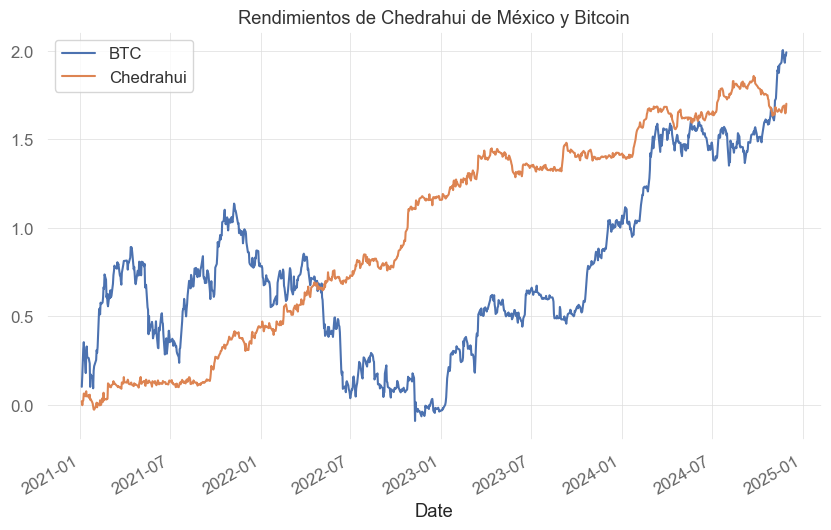

In [84]:
mex_acc_btc_r['BTC'].cumsum().plot(figsize=(10, 6), title='Rendimientos de Chedrahui de México y Bitcoin')
mex_acc_btc_r['CHDRAUIB.MX'].cumsum().plot()
# para añadir leyenda de Color se usa
plt.legend(['BTC', 'Chedrahui'])